# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias_shape=azdias.shape
feat_shape=feat_info.shape

print(f'azdias shape is {azdias_shape}. feat shape is {feat_shape}')

azdias.head(10)


azdias shape is (891221, 85). feat shape is (85, 4)


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   
5         3                     1          2            2.0   
6        -1                     2          2            5.0   
7        -1                     1          1            3.0   
8        -1                     3          1            3.0   
9        -1                     3          2            4.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   
5                  3              1                 5               2   
6                  1              5                 1               5   
7                  3              3                 4               1   
8                  4              4                 2               4   
9                  2              4                 2               3   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   
5                      2                 5    ...            2.0         3.0   
6                      4                 3    ...            3.0         3.0   
7                      3                 2    ...            3.0         3.0   
8                      2                 2    ...            2.0         3.0   
9                      5                 4    ...            2.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   
5         1.0         1.0          1.0       5.0       5.0     2.0   
6         1.0         0.0          1.0       5.0       5.0     4.0   
7         1.0         0.0          1.0       4.0       4.0     2.0   
8         2.0         1.0          1.0       3.0       3.0     2.0   
9         2.0         1.0          1.0       3.0       3.0     2.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  
5          3.0       3.0  
6          6.0       3.0  
7          5.0       2.0  
8          4.0       3.0  
9          3.0       1.0  

[10 rows x 85 columns]

In [4]:
feat_info.head(5)

attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

The following will replace the indexes with np.na in the dataframe:

In [5]:
feat_list = feat_info['missing_or_unknown'].tolist()
missing_list = []

for i in feat_list:
    subcount = 0
    i = i.replace('[', '')
    i = i.replace(']', '')
    i = i.split(',')
    missing_list.append(i)

In [6]:
def replace(value, items, **kwargs):
    for i in items:
        try:
            if value == np.int(i):
                return np.nan
            else:
                pass
        except ValueError:
            if value == str(i):
                return np.nan
            else:
                pass
    return value

In [7]:
for col, index in zip(azdias, range(len(missing_list))):
    print(col, index)
    azdias.iloc[:,index] = azdias.iloc[:,index].apply(replace, items=missing_list[index], axis=1)

AGER_TYP 0
ALTERSKATEGORIE_GROB 1
ANREDE_KZ 2
CJT_GESAMTTYP 3
FINANZ_MINIMALIST 4
FINANZ_SPARER 5
FINANZ_VORSORGER 6
FINANZ_ANLEGER 7
FINANZ_UNAUFFAELLIGER 8
FINANZ_HAUSBAUER 9
FINANZTYP 10
GEBURTSJAHR 11
GFK_URLAUBERTYP 12
GREEN_AVANTGARDE 13
HEALTH_TYP 14
LP_LEBENSPHASE_FEIN 15
LP_LEBENSPHASE_GROB 16
LP_FAMILIE_FEIN 17
LP_FAMILIE_GROB 18
LP_STATUS_FEIN 19
LP_STATUS_GROB 20
NATIONALITAET_KZ 21
PRAEGENDE_JUGENDJAHRE 22
RETOURTYP_BK_S 23
SEMIO_SOZ 24
SEMIO_FAM 25
SEMIO_REL 26
SEMIO_MAT 27
SEMIO_VERT 28
SEMIO_LUST 29
SEMIO_ERL 30
SEMIO_KULT 31
SEMIO_RAT 32
SEMIO_KRIT 33
SEMIO_DOM 34
SEMIO_KAEM 35
SEMIO_PFLICHT 36
SEMIO_TRADV 37
SHOPPER_TYP 38
SOHO_KZ 39
TITEL_KZ 40
VERS_TYP 41
ZABEOTYP 42
ALTER_HH 43
ANZ_PERSONEN 44
ANZ_TITEL 45
HH_EINKOMMEN_SCORE 46
KK_KUNDENTYP 47
W_KEIT_KIND_HH 48
WOHNDAUER_2008 49
ANZ_HAUSHALTE_AKTIV 50
ANZ_HH_TITEL 51
GEBAEUDETYP 52
KONSUMNAEHE 53
MIN_GEBAEUDEJAHR 54
OST_WEST_KZ 55
WOHNLAGE 56
CAMEO_DEUG_2015 57
CAMEO_DEU_2015 58
CAMEO_INTL_2015 59
KBA05_ANTG1 60
KB

In [8]:
azdias.head(20)

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        NaN                   2.0          1            2.0   
1        NaN                   1.0          2            5.0   
2        NaN                   3.0          2            3.0   
3        2.0                   4.0          2            2.0   
4        NaN                   3.0          1            5.0   
5        3.0                   1.0          2            2.0   
6        NaN                   2.0          2            5.0   
7        NaN                   1.0          1            3.0   
8        NaN                   3.0          1            3.0   
9        NaN                   3.0          2            4.0   
10       NaN                   3.0          2            1.0   
11       NaN                   2.0          1            6.0   
12       NaN                   3.0          1            6.0   
13       NaN                   1.0          2            5.0   
14       NaN                   3.0          1            6.0   
15       1.0                   4.0          2            4.0   
16       NaN                   1.0          2            1.0   
17       NaN                   2.0          1            6.0   
18       NaN                   2.0          2            6.0   
19       NaN                   3.0          1            3.0   

    FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                   3              4                 3               5   
1                   1              5                 2               5   
2                   1              4                 1               2   
3                   4              2                 5               2   
4                   4              3                 4               1   
5                   3              1                 5               2   
6                   1              5                 1               5   
7                   3              3                 4               1   
8                   4              4                 2               4   
9                   2              4                 2               3   
10                  2              2                 5               3   
11                  3              4                 3               5   
12                  5              3                 4               2   
13                  1              4                 3               5   
14                  3              4                 3               5   
15                  4              1                 5               1   
16                  4              3                 1               4   
17                  3              4                 3               5   
18                  2              4                 1               5   
19                  5              2                 3               1   

    FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                       5                 3    ...            NaN         NaN   
1                       4                 5    ...            2.0         3.0   
2                       3                 5    ...            3.0         3.0   
3                       1                 2    ...            2.0         2.0   
4                       3                 2    ...            2.0         4.0   
5                       2                 5    ...            2.0         3.0   
6                       4                 3    ...            3.0         3.0   
7                       3                 2    ...            3.0         3.0   
8                       2                 2    ...            2.0         3.0   
9                       5                 4    ...            2.0         3.0   
10                      1                 5    ...            2.0         4.0   
11                      5                 3    ...            NaN         NaN   
12                      4                 1    ... 

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

## Answer

Rather than using a histogram which is cumbersome to plot, we can achieve the same result by finding how many missing values make up the entire column. We can sort this in descending order and we can see which columns have the most missing values.

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
import seaborn as sns
import matplotlib.pyplot as plt

null_col_count = azdias.isnull().sum(axis=0)
# print(null_col_count)

In [10]:
ax_rows = azdias.shape[0]

In [11]:
def findTotal(value, total):
    return value/total

In [12]:
anomalies = null_col_count.apply(findTotal, total=ax_rows).sort_values(ascending=False)

## Answer

There are six columns that I would consdier to be anomalies in terms of missing values, they are:

In [13]:
anomalies[0:6]

TITEL_KZ        0.997576
AGER_TYP        0.769554
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
GEBURTSJAHR     0.440203
ALTER_HH        0.348137
dtype: float64

We can drop these columns:

In [14]:
azdias.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], axis=1, inplace=True)

In [15]:
assert azdias_shape[1]-6 == azdias.shape[1]

## Answer

To find patterns we can use seaborn heatmap with pd.isnull()

In [16]:
azdias.shape[1]

79

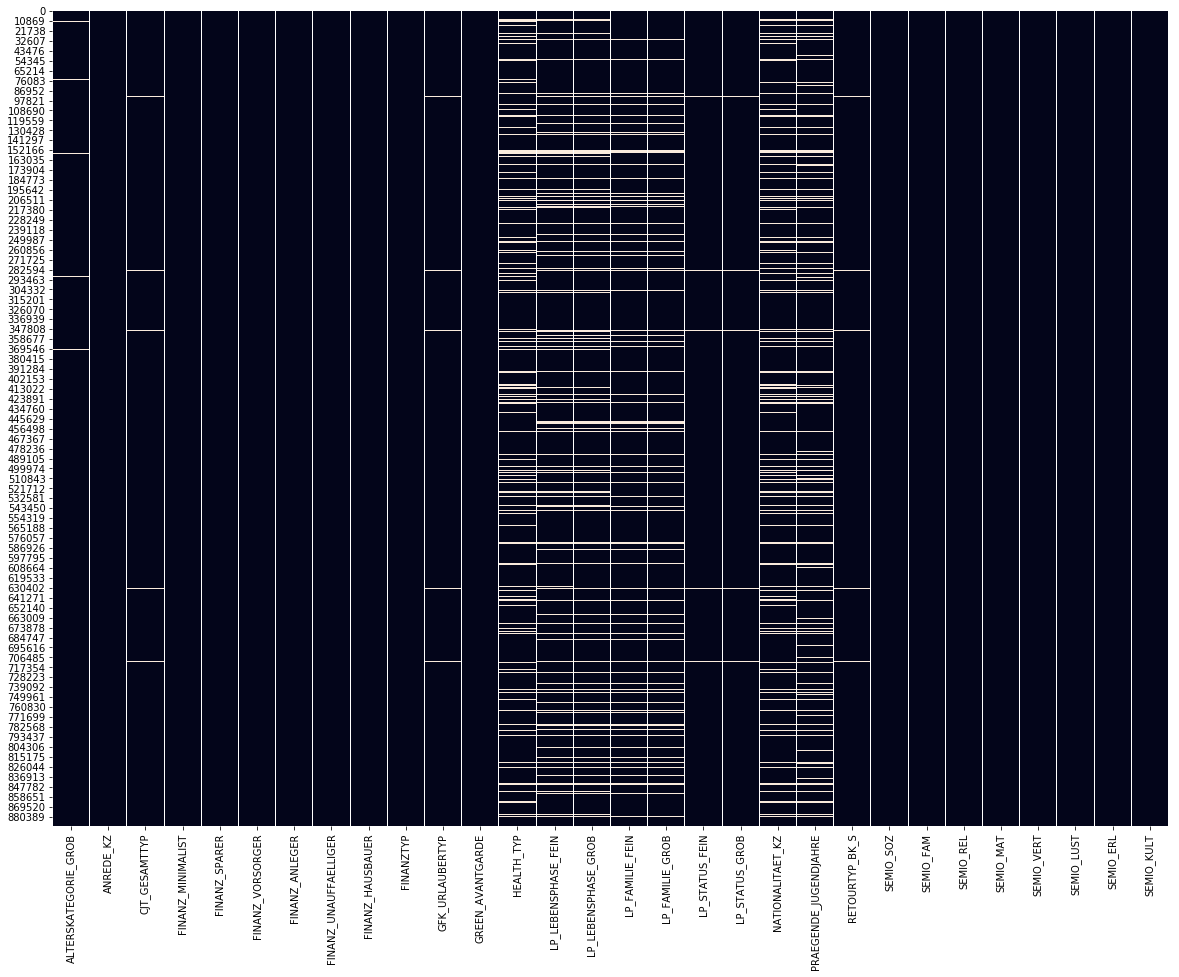

In [17]:
plt.subplots(figsize=(20,15))
sns.heatmap(azdias.iloc[:,0:30].isnull(), cbar=False)

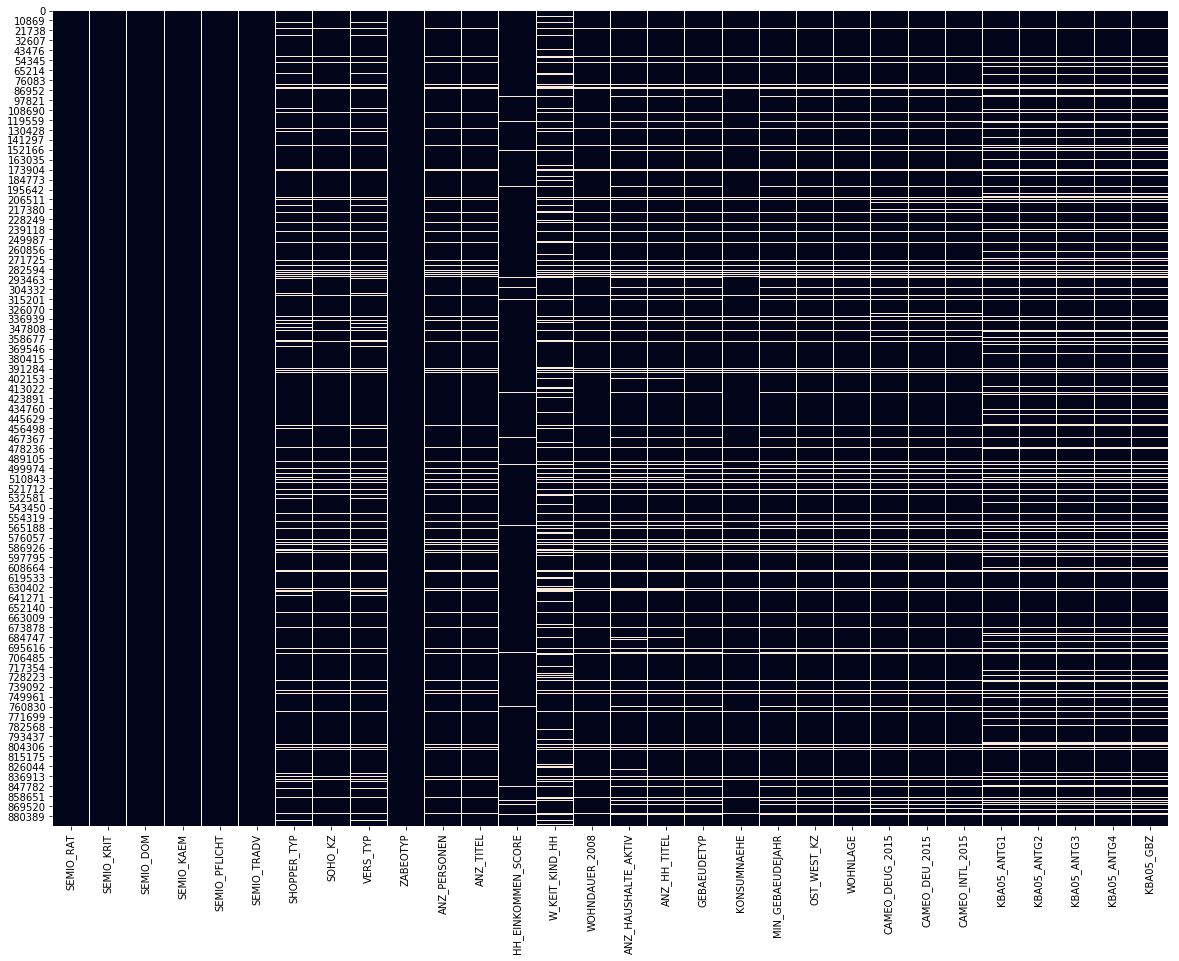

In [18]:
plt.subplots(figsize=(20,15))
sns.heatmap(azdias.iloc[:,30:60].isnull(), cbar=False)

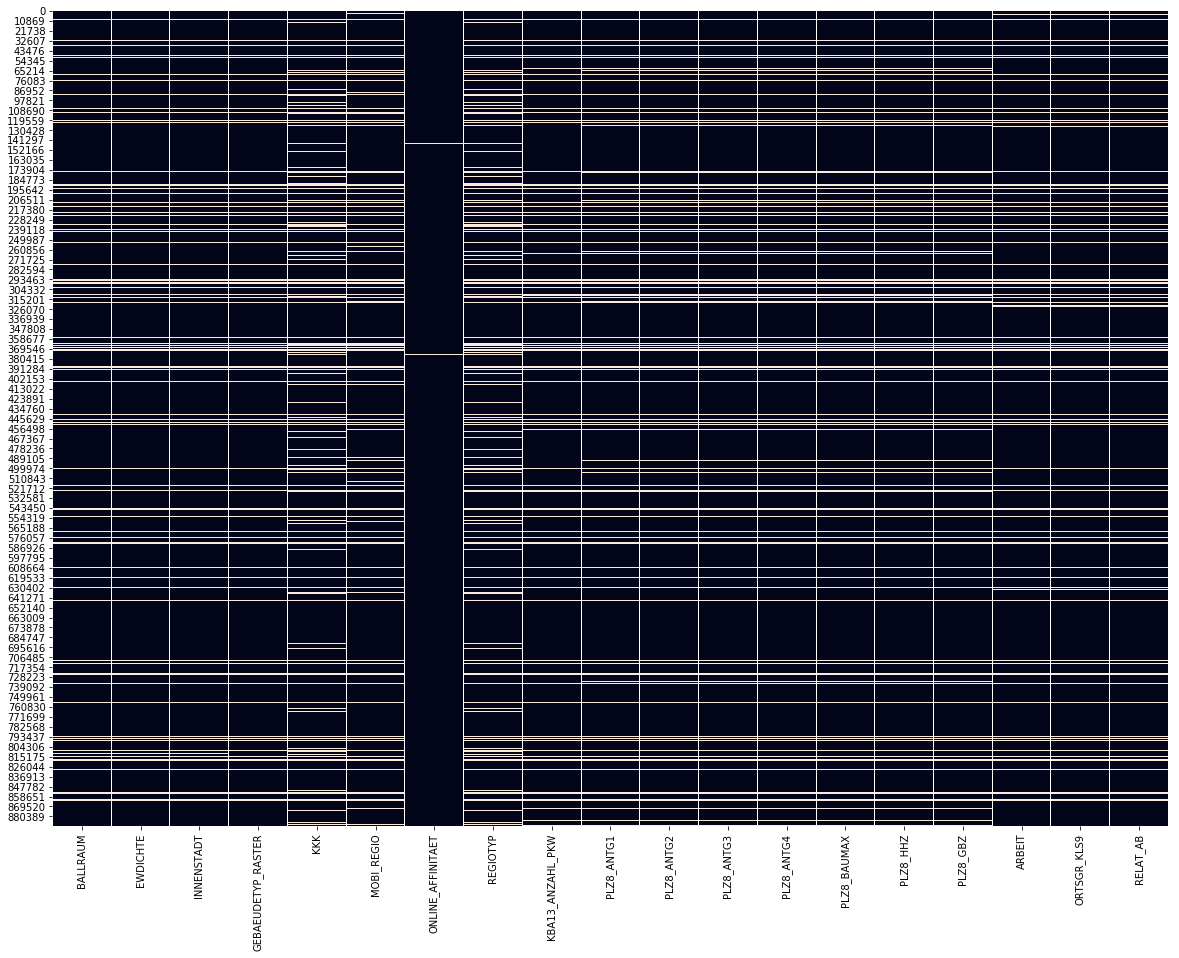

In [19]:
plt.subplots(figsize=(20,15))
sns.heatmap(azdias.iloc[:,60:80].isnull(), cbar=False)

In [20]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

columnList = azdias.columns.values
columnPatternIndexes = [12, 13, 14, 15 ,16 , 19, 20, 36, 37, 38, 40, 41, 43, 44, 46,
                        46, 47, 48, 49, 50 ,51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
                        61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
                        77, 78]
print(f'Total no. of columns with pattern in nan values: {len(columnPatternIndexes)}')
print(f'Total no. of columns without pattern in nan values: {len(columnList)-len(columnPatternIndexes)}')
# print(f'{anomalies[6:]}')

Total no. of columns with pattern in nan values: 47
Total no. of columns without pattern in nan values: 32


## Answer

#### Discussion 1.1.2: Assess Missing Data in Each Column

In total I found 6 columns that I determined to have unusually high levels of nan values for the data and as such I dropped them from the dataframe.

I found 47 columns that appear to have a pattern in missing data. We can see that this pattern is fairly consistent throughout the dataset. 

**There are a lot of columns in this data set**, however looking through the data dictionary I can see that many of the categories are of the form:

N (detailed scale) or (rough scale)

where N could be anything from Wealth status to family. As the data is looking at regional areas, it makes sense that if data is missing for one area, it would be missing for all the other categories as well.

For example, PLZ8_ANTG1, PLZ8_ANTG2 and PLZ8_ANTG3 all describe the number of family houses in the PLZ8 region by size of family (1-2 people, 3-5 people etc). If this information is missing in PLZ8_ANTG1, then it makes sense that is also missing in the same region for the other categories. **This could explain why we see patterns throughout the entire dataset**

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

## Answer

We can repeat what we did above but for the rows. I will transpose the dataframe and repeat the same steps as before.

In [21]:
## Testing ignore this cell

# How much data is missing in each row of the dataset?
null_row_count = azdias.isnull().sum(axis=1)
null_row_count = pd.DataFrame(null_row_count)
null_row_count.columns = ['null_count']
# null_row_count.sample(frac=1).head(30)
# null_row_count.groupby('null_count').agg({'null_count': 'count'})

In [22]:
azdiasT = azdias.transpose()
azdiasT.head(2)

0      1      2      3      4      5      6      7       \
ALTERSKATEGORIE_GROB      2      1      3      4      3      1      2      1   
ANREDE_KZ                 1      2      2      2      1      2      2      1   

                     8      9       ...   891211 891212 891213 891214 891215  \
ALTERSKATEGORIE_GROB      3      3  ...        3      4      4      1      2   
ANREDE_KZ                 1      2  ...        1      1      2      2      2   

                     891216 891217 891218 891219 891220  
ALTERSKATEGORIE_GROB      3      2      2      1      4  
ANREDE_KZ                 2      1      2      1      1  

[2 rows x 891221 columns]

In [23]:
null_row_count = azdiasT.isnull().sum(axis=0)

axT_rows = azdiasT.shape[0]
print(axT_rows)

79


In [24]:
print(null_row_count.head(5))
print()
print(null_row_count.shape)

0    43
1     0
2     0
3     7
4     0
dtype: int64

(891221,)


In [25]:
anomaliesT_f = null_row_count.apply(findTotal, total=axT_rows).sort_values(ascending=False)
anomaliesT_f.head(5)

643174    0.620253
732775    0.620253
472919    0.607595
183108    0.594937
139316    0.594937
dtype: float64

In [26]:
anomaliesT_f = pd.DataFrame(anomaliesT_f)
# anomaliesT.iloc[0:5,0]
print(anomaliesT_f.describe())

                   0
count  891221.000000
mean        0.071518
std         0.167528
min         0.000000
25%         0.000000
50%         0.000000
75%         0.037975
max         0.620253


In [27]:
for i in range(85, 92):
    print(f'{i}% percentile: {anomaliesT_f.quantile(q=i*0.01)[0]:.4f}')
limit = anomaliesT_f.quantile(q=0.9)[0]
print(f'\nLimit is {limit}')

85% percentile: 0.1013
86% percentile: 0.1013
87% percentile: 0.1266
88% percentile: 0.1646
89% percentile: 0.2025
90% percentile: 0.4304
91% percentile: 0.4304

Limit is 0.43037974683544306


## Answer

As there is a much larger jump from the 89th to 90th percentile (a factor of around 113%) I would say our threshold for the split for the rows should be those which have 43% or higher missing values of the total data in the top category (denoted as anomaliesU), and those that are less than 43% in the bottom category (denoted as anomaliesL).

In [28]:
import collections
print(collections.Counter(null_row_count))

Counter({0: 623209, 47: 45578, 2: 27926, 43: 27369, 8: 24592, 5: 22515, 3: 17629, 1: 15738, 6: 13771, 7: 13714, 4: 12607, 34: 10816, 10: 5410, 15: 4743, 35: 3911, 13: 3255, 9: 3042, 33: 2985, 16: 2505, 14: 2243, 19: 1180, 11: 1127, 12: 766, 17: 677, 37: 538, 45: 494, 18: 428, 38: 421, 41: 356, 20: 349, 32: 206, 44: 155, 21: 150, 40: 137, 23: 132, 22: 129, 36: 84, 39: 77, 24: 69, 26: 59, 25: 55, 27: 24, 42: 21, 29: 12, 30: 6, 28: 5, 31: 3, 49: 2, 48: 1})


## Answer
We will now split the dataframe into 2 categories, and then compare the columns of the original matrix like before

In [29]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.a
anomaliesU = anomaliesT_f[(anomaliesT_f>=limit)]
anomaliesU.dropna(inplace=True)
print(anomaliesU.describe())

                  0
count  89960.000000
mean       0.550983
std        0.057724
min        0.430380
25%        0.544304
50%        0.594937
75%        0.594937
max        0.620253


In [30]:
anomaliesL = anomaliesT_f[(anomaliesT_f<limit)]
anomaliesL.dropna(inplace=True)
print(anomaliesL.describe())

                   0
count  801261.000000
mean        0.017687
std         0.046201
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.417722


## Answer

We check that our dataframes match the original row totals:

In [31]:
assert ((anomaliesL.shape[0] + anomaliesU.shape[0]) == azdias.shape[0])

In [32]:
print(f'We have droped {100*anomaliesU.shape[0]/azdias.shape[0]:.0f}% of rows')

We have droped 10% of rows


## Answer

As we took the 90th percentile, this confirms we have dropped the right amount. I am unsure at this stage if we have dropped too much. For the sake of the project I will commit to the values I initially chose, and only revise this later if we see a huge detriment to the model.

In [33]:
# anomaliesT.iloc[anomaliesU.index]
anomaliesU = azdias.iloc[anomaliesU.index]

In [34]:
print(anomaliesU.shape)
print(anomaliesU.sample(frac=True).head(10))

(89960, 79)
        ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
455227                   2.0          2            1.0                  3   
7661                     1.0          2            4.0                  1   
581535                   4.0          2            5.0                  4   
523278                   2.0          1            4.0                  5   
109567                   2.0          2            6.0                  3   
545797                   3.0          1            5.0                  5   
473310                   3.0          2            6.0                  3   
246673                   1.0          2            6.0                  3   
747422                   3.0          1            4.0                  3   
765381                   2.0          2            6.0                  3   

        FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
455227              4                 3               5   
7661                5 

In [35]:
anomaliesL = azdias.iloc[anomaliesL.index]

In [36]:
print(anomaliesL.shape)
print(anomaliesL.sample(frac=True).head(10))

(801261, 79)
        ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
553242                   4.0          1            1.0                  3   
169994                   2.0          1            3.0                  4   
14476                    4.0          1            5.0                  5   
686628                   3.0          1            4.0                  4   
477351                   3.0          2            4.0                  4   
749545                   1.0          2            3.0                  1   
559934                   4.0          1            2.0                  4   
760686                   3.0          1            4.0                  2   
395366                   3.0          2            3.0                  1   
568884                   3.0          2            6.0                  5   

        FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
553242              1                 5               1   
169994              2

## Answer

As directed, we will now look at collumns against these two groups. Recall that we have columnPatternIndexes as a list of columns that have a lot of missing values from before, we can drop these columns and sample at random against the remaining columns to see if we can see anything interesting.

In [37]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
print(f'Number of cols to drop: {len(columnPatternIndexes)}')
anomaliesL_compare = anomaliesL.drop(anomaliesL.iloc[:,columnPatternIndexes], axis=1)
print(f'Number of cols kept: {anomaliesL_compare.shape[1]}')
anomaliesL_compare.head(10)

Number of cols to drop: 47
Number of cols kept: 33


ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
830954                   1.0          2            3.0                  1   
829381                   3.0          2            1.0                  4   
841875                   1.0          1            4.0                  2   
848175                   2.0          1            3.0                  4   
818489                   1.0          2            4.0                  3   
215572                   1.0          1            4.0                  2   
83951                    3.0          1            5.0                  5   
284735                   2.0          1            4.0                  4   
258200                   1.0          2            6.0                  2   
388735                   3.0          1            6.0                  5   

        FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
830954              5                 3               5   
829381              2                 4               4   
841875              5                 3               5   
848175              4                 2               4   
818489              4                 2               5   
215572              5                 3               5   
83951               3                 4               3   
284735              4                 2               4   
258200              5                 3               5   
388735              2                 5               2   

        FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP        ...          \
830954                      5                 3          1        ...           
829381                      3                 1          3        ...           
841875                      5                 2          1        ...           
848175                      5                 1          3        ...           
818489                      5                 2          4        ...           
215572                      5                 2          1        ...           
83951                       3                 1          3        ...           
284735                      5                 1          3        ...           
258200                      5                 4          1        ...           
388735                      3                 2          2        ...           

        SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  \
830954          6           7          6           6              5   
829381          4           7          6           7              4   
841875          4           1          2           4              5   
848175          5           1          2           2              5   
818489          6           7          6           6              5   
215572          5           1          2           4              5   
83951           5           3          2           3              4   
284735          4           1          2           2              5   
258200          6           7          6           6              5   
388735          5           3          2           3              4   

        SEMIO_TRADV  ZABEOTYP  HH_EINKOMMEN_SCORE  ANZ_HAUSHALTE_AKTIV  \
830954            6         5                 NaN                  NaN   
829381            3         3                 NaN                  NaN   
841875            5         1                 2.0                  NaN   
848175            5         5                 2.0                  NaN   
818489            6         5                 NaN                  NaN   
215572            5         5                 NaN                  NaN   
83951             4         6                 NaN                  NaN   
284735            5         5                 NaN                  NaN   
258200            6         4                 NaN                  NaN   
388735            4         3                 NaN                  NaN   

        ONLINE_AFFINI

In [38]:
import random

def dataComparison(df):
    cols = random.sample(list(df.columns.values), 5)
    f, axes = plt.subplots(1, 5, figsize=(25,4))
    for i in range(0, 5):
        sns.countplot(x=cols[i], data=df.fillna('Missing'), ax=axes[i])  

## Answer
Let's look at the data distribution for the Lower group (those that don't have many zero values across the rows)

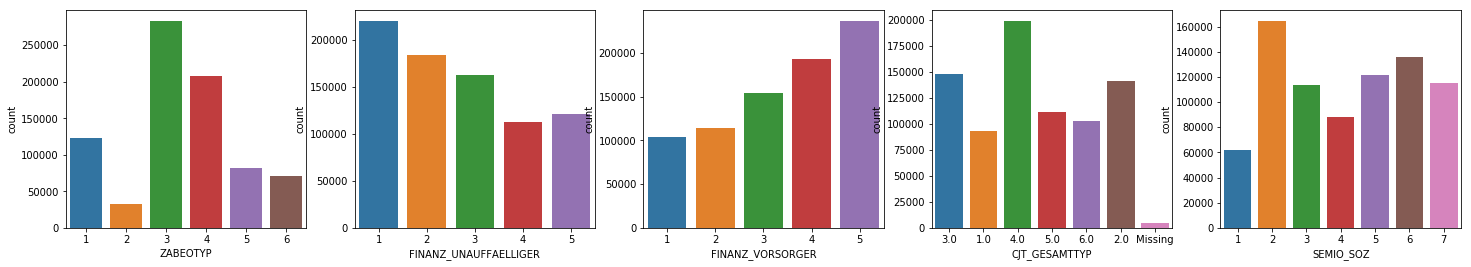

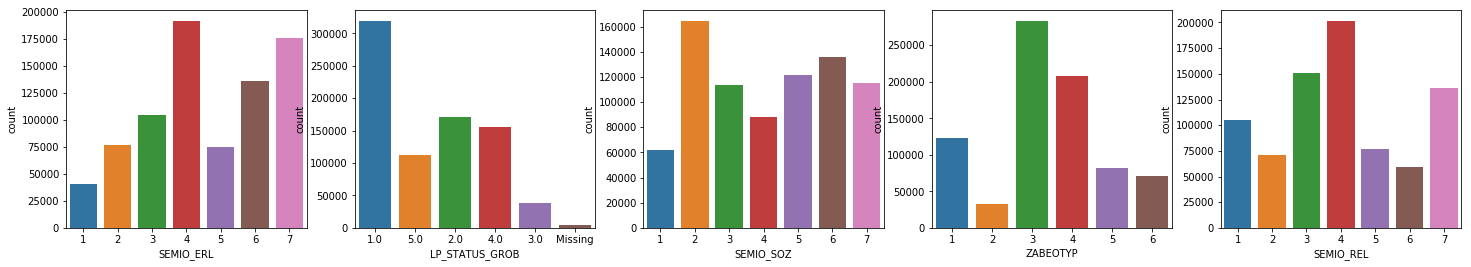

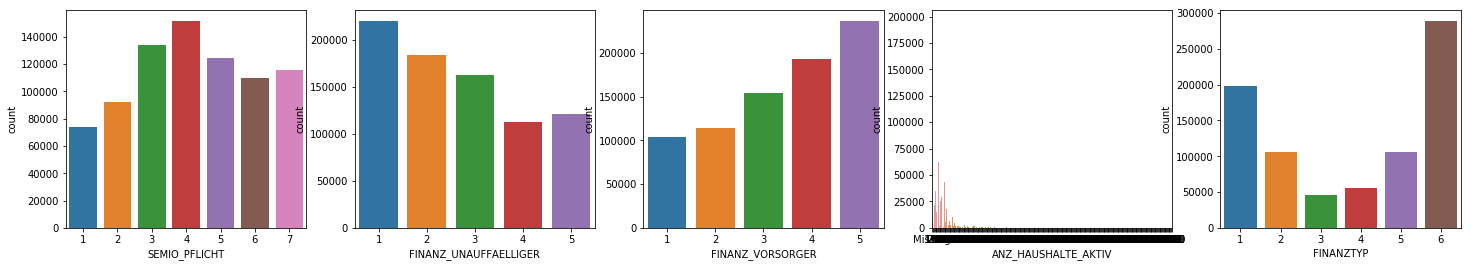

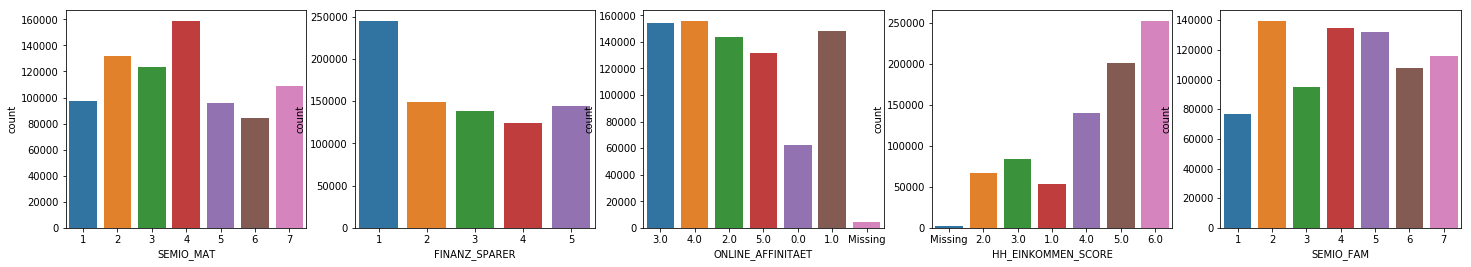

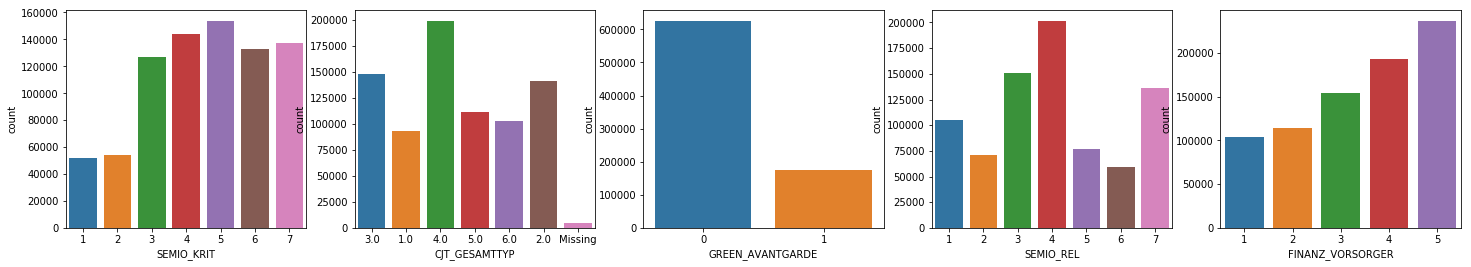

In [39]:
import itertools

for _ in itertools.repeat(None, 5):
    dataComparison(anomaliesL_compare)

## Answer
Now the same for the upper group

In [40]:
print(f'Number of cols to drop: {len(columnPatternIndexes)}')
anomaliesU_compare = anomaliesU.drop(anomaliesU.iloc[:,columnPatternIndexes], axis=1)
print(f'Number of cols kept: {anomaliesU_compare.shape[1]}')
anomaliesU_compare.head(10)

Number of cols to drop: 47
Number of cols kept: 33


ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
643174                   3.0          1            NaN                  2   
732775                   3.0          2            NaN                  3   
472919                   1.0          1            NaN                  5   
183108                   1.0          2            6.0                  3   
139316                   3.0          2            6.0                  3   
691141                   1.0          1            6.0                  3   
691142                   3.0          2            6.0                  3   
691171                   3.0          1            6.0                  3   
691183                   3.0          1            6.0                  3   
139332                   3.0          1            6.0                  3   

        FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
643174              5                 3               5   
732775              5                 3               5   
472919              1                 5               2   
183108              4                 3               5   
139316              4                 3               5   
691141              4                 3               5   
691142              4                 3               5   
691171              4                 3               5   
691183              4                 3               5   
139332              4                 3               5   

        FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP        ...          \
643174                      5                 2          4        ...           
732775                      5                 2          4        ...           
472919                      3                 2          2        ...           
183108                      5                 3          4        ...           
139316                      5                 3          4        ...           
691141                      5                 3          4        ...           
691142                      5                 3          4        ...           
691171                      5                 3          4        ...           
691183                      5                 3          4        ...           
139332                      5                 3          4        ...           

        SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  \
643174          5           4          4           4              5   
732775          4           7          6           6              5   
472919          4           4          4           4              5   
183108          4           7          6           6              5   
139316          4           7          6           6              5   
691141          4           7          6           6              5   
691142          4           7          6           6              5   
691171          4           7          6           6              5   
691183          4           7          6           6              5   
139332          4           7          6           6              5   

        SEMIO_TRADV  ZABEOTYP  HH_EINKOMMEN_SCORE  ANZ_HAUSHALTE_AKTIV  \
643174            4         4                 NaN                  NaN   
732775            3         3                 NaN                  NaN   
472919            4         6                 NaN                  NaN   
183108            3         3                 2.0                  NaN   
139316            3         3                 2.0                  NaN   
691141            3         3                 2.0                  NaN   
691142            3         3                 2.0                  NaN   
691171            3         3                 2.0                  NaN   
691183            3         3                 2.0                  NaN   
139332            3         3                 2.0                  NaN   

        ONLINE_AFFINI

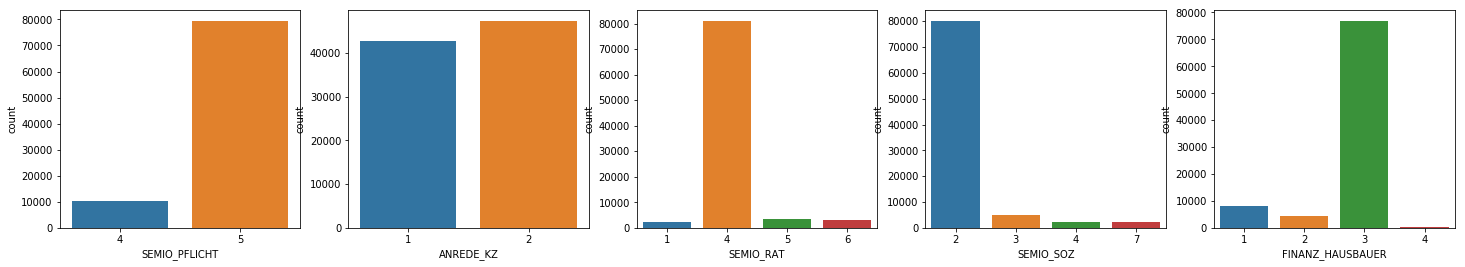

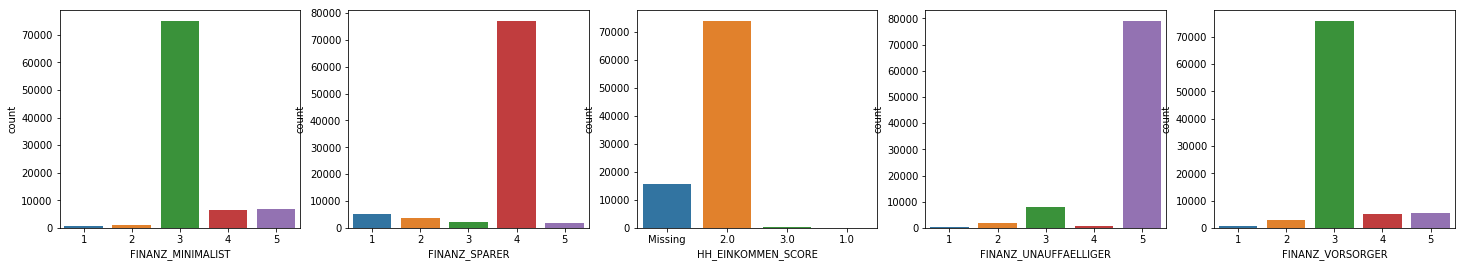

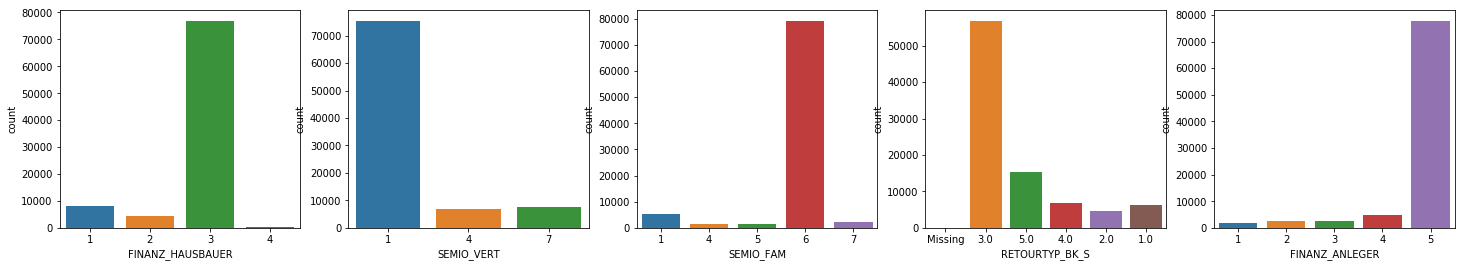

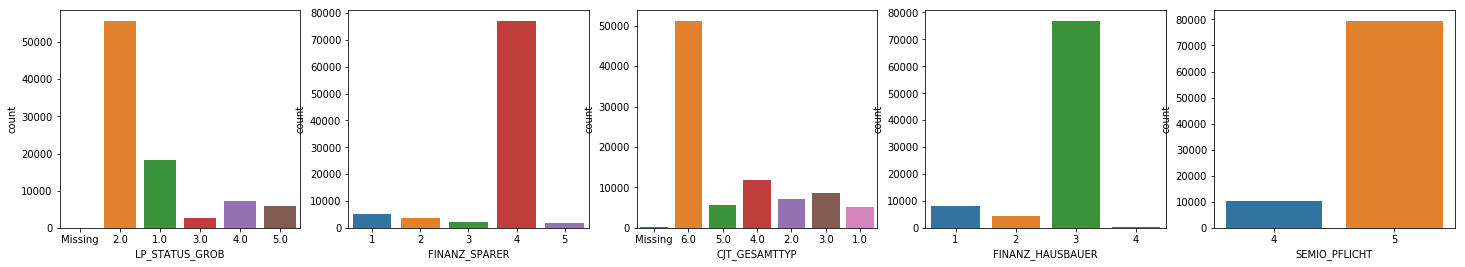

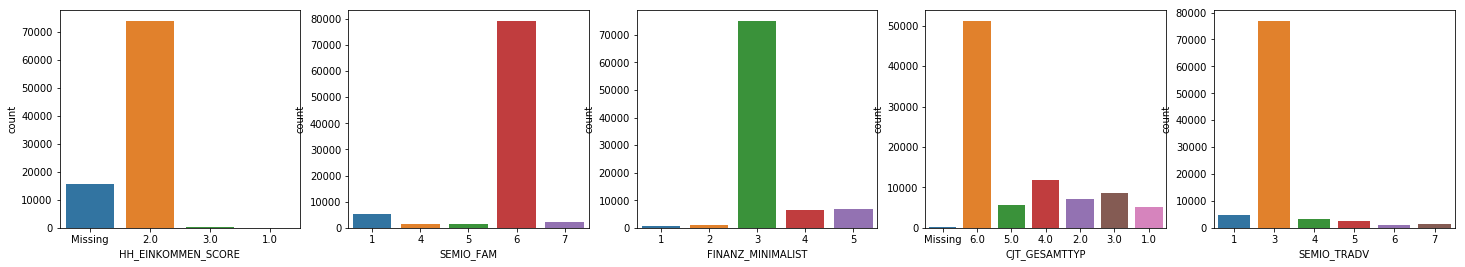

In [41]:
for _ in itertools.repeat(None, 5):
    dataComparison(anomaliesU_compare)

#### Discussion 1.1.3: Assess Missing Data in Each Row

There is a huge distance that is faily easy to visualise from the above graphs. We can see that the group that is below the threshold looks very reasonable. Without doing any specific statistical analysis we can see that across most columns, the data is fairly evenly spread. With a good mix between the columns - the point to take away is across the columns, the data doesn't look to follow a pattern. 


Looking at the group which contains the rows above the threshold we can see immediately the data is largely dominated by a single value in each column. Looking at the column ANZ_HAUSHALTE_AKTIV we can see that this column is dominated with missing values exlusively from this rows. This means that all the information we have for this column will come from the other set of rows.

This is a very interesting factor in our data. If we think about it, if a row has a large number of missing values, then there must be only a few cells in that row that contain the information. If we take the columns that we know contain mostly data and not many nan values (as we have exlucded both of these earlier on), then we can see that these rows account for the dominating value. 

We can see this from the above graph where SEMIO_Lust is dominated with the value 5 in these upper rows, whereas in the lower group SEMIO_Lust is fairly evenly spread out, with 6, 7 being the two highest values and 5 actually being second from the bottom.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [42]:
# How many features are there of each data type?
collections.Counter(feat_info['type'].values)


Counter({'categorical': 21,
         'ordinal': 49,
         'numeric': 7,
         'mixed': 7,
         'interval': 1})

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [43]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_info_cat = feat_info[(feat_info['type']=='categorical')]
feat_info_cat

attribute information_level         type missing_or_unknown
0           AGER_TYP            person  categorical             [-1,0]
2          ANREDE_KZ            person  categorical             [-1,0]
3      CJT_GESAMTTYP            person  categorical                [0]
10         FINANZTYP            person  categorical               [-1]
12   GFK_URLAUBERTYP            person  categorical                 []
13  GREEN_AVANTGARDE            person  categorical                 []
17   LP_FAMILIE_FEIN            person  categorical                [0]
18   LP_FAMILIE_GROB            person  categorical                [0]
19    LP_STATUS_FEIN            person  categorical                [0]
20    LP_STATUS_GROB            person  categorical                [0]
21  NATIONALITAET_KZ            person  categorical             [-1,0]
38       SHOPPER_TYP            person  categorical               [-1]
39           SOHO_KZ            person  categorical               [-1]
40          TITEL_KZ            person  categorical             [-1,0]
41          VERS_TYP            person  categorical               [-1]
42          ZABEOTYP            person  categorical             [-1,9]
47      KK_KUNDENTYP         household  categorical               [-1]
52       GEBAEUDETYP          building  categorical             [-1,0]
55       OST_WEST_KZ          building  categorical               [-1]
57   CAMEO_DEUG_2015     microcell_rr4  categorical             [-1,X]
58    CAMEO_DEU_2015     microcell_rr4  categorical               [XX]

## Answer

We pick the attribute column, which gives us the columns for our data.

We need to remember to drop the columns from this list that we removed at the start of the project, as they were mostly missing values.

In [44]:
categorical_cols = feat_info_cat['attribute'].tolist()

drop_cols = ['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP']

for i in drop_cols:
    categorical_cols.remove(i)
    
print(categorical_cols)
print(len(categorical_cols))

['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
18


## Answer

We will drop from this list the columns that contain just two values. **Note I am dropping them if the length of their unique values is equal to 2. This is because we know that we do not have any columns that have a length of two with non numeric values. This method would not extend to a case where we have 2 non-numeric values**

In [45]:
# Re-encode categorical variable(s) to be kept in the analysis.
for i in categorical_cols:
    print(f'{i}\nValues: {azdias[i].unique()}\nLength: {len(azdias[i].unique())}')
    if len(azdias[i].unique()) == 2:
        categorical_cols.remove(i)
print('\n Columns to reencode as dummies:', categorical_cols)

ANREDE_KZ
Values: [1 2]
Length: 2
FINANZTYP
Values: [4 1 6 5 2 3]
Length: 6
GFK_URLAUBERTYP
Values: [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
Length: 13
GREEN_AVANTGARDE
Values: [0 1]
Length: 2
LP_FAMILIE_GROB
Values: [  2.   3.   1.  nan   5.   4.]
Length: 6
LP_STATUS_FEIN
Values: [  1.   2.   3.   9.   4.  10.   5.   8.   6.   7.  nan]
Length: 11
LP_STATUS_GROB
Values: [  1.   2.   4.   5.   3.  nan]
Length: 6
NATIONALITAET_KZ
Values: [ nan   1.   3.   2.]
Length: 4
SHOPPER_TYP
Values: [ nan   3.   2.   1.   0.]
Length: 5
SOHO_KZ
Values: [ nan   1.   0.]
Length: 3
VERS_TYP
Values: [ nan   2.   1.]
Length: 3
ZABEOTYP
Values: [3 5 4 1 6 2]
Length: 6
GEBAEUDETYP
Values: [ nan   8.   1.   3.   2.   6.   4.   5.]
Length: 8
OST_WEST_KZ
Values: [nan 'W' 'O']
Length: 3
CAMEO_DEUG_2015
Values: [nan '8' '4' '2' '6' '1' '9' '5' '7' '3']
Length: 10
CAMEO_DEU_2015
Values: [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' 

In [46]:
len(categorical_cols)

16

In [47]:
azdias[categorical_cols].head(5)

CJT_GESAMTTYP  FINANZTYP  GFK_URLAUBERTYP  LP_FAMILIE_FEIN  \
0            2.0          4             10.0              2.0   
1            5.0          1             10.0              5.0   
2            3.0          1             10.0              1.0   
3            2.0          6              1.0              NaN   
4            5.0          5              5.0             10.0   

   LP_FAMILIE_GROB  LP_STATUS_FEIN  LP_STATUS_GROB  NATIONALITAET_KZ  \
0              2.0             1.0             1.0               NaN   
1              3.0             2.0             1.0               1.0   
2              1.0             3.0             2.0               1.0   
3              NaN             9.0             4.0               1.0   
4              5.0             3.0             2.0               1.0   

   SHOPPER_TYP  SOHO_KZ  VERS_TYP  ZABEOTYP  GEBAEUDETYP OST_WEST_KZ  \
0          NaN      NaN       NaN         3          NaN         NaN   
1          3.0      1.0       2.0         5          8.0           W   
2          2.0      0.0       1.0         5          1.0           W   
3          1.0      0.0       1.0         3          1.0           W   
4          2.0      0.0       2.0         4          1.0           W   

  CAMEO_DEUG_2015 CAMEO_DEU_2015  
0             NaN            NaN  
1               8             8A  
2               4             4C  
3               2             2A  
4               6             6B

In [48]:
azdias_cat_dummies = pd.get_dummies(azdias[categorical_cols].astype(str))
azdias_cat_dummies.head(5)

CJT_GESAMTTYP_1.0  CJT_GESAMTTYP_2.0  CJT_GESAMTTYP_3.0  CJT_GESAMTTYP_4.0  \
0                  0                  1                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  1                  0   
3                  0                  1                  0                  0   
4                  0                  0                  0                  0   

   CJT_GESAMTTYP_5.0  CJT_GESAMTTYP_6.0  CJT_GESAMTTYP_nan  FINANZTYP_1  \
0                  0                  0                  0            0   
1                  1                  0                  0            1   
2                  0                  0                  0            1   
3                  0                  0                  0            0   
4                  1                  0                  0            0   

   FINANZTYP_2  FINANZTYP_3         ...          CAMEO_DEU_2015_8A  \
0            0            0         ...                          0   
1            0            0         ...                          1   
2            0            0         ...                          0   
3            0            0         ...                          0   
4            0            0         ...                          0   

   CAMEO_DEU_2015_8B  CAMEO_DEU_2015_8C  CAMEO_DEU_2015_8D  CAMEO_DEU_2015_9A  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   CAMEO_DEU_2015_9B  CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  CAMEO_DEU_2015_9E  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   CAMEO_DEU_2015_nan  
0                   1  
1                   0  
2                   0  
3                   0  
4                   0  

[5 rows x 148 columns]

#### Discussion 1.2.1: Re-Encode Categorical Features


There were 18 of the type 'categorical' that we needed to work with. They were:

['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

ANREDE_KZ was binary numerical so we were able to drop it.

CAMEO_DEU_2015 had multiple strings as its values. We will use dummy variables on this.

The remaining 16 columns were multi-level categoricals. I used pd.get_dummies() to convert these to dummy variables.

These 16 become 148 columns of dummy variables. All we need to do now is to drop the columns from the original dataframe, and replace them with these.



#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [49]:
feat_info_mixed = feat_info[(feat_info['type']=='mixed')]
feat_info_mixed

attribute information_level   type missing_or_unknown
15    LP_LEBENSPHASE_FEIN            person  mixed                [0]
16    LP_LEBENSPHASE_GROB            person  mixed                [0]
22  PRAEGENDE_JUGENDJAHRE            person  mixed             [-1,0]
56               WOHNLAGE          building  mixed               [-1]
59        CAMEO_INTL_2015     microcell_rr4  mixed            [-1,XX]
64           KBA05_BAUMAX     microcell_rr3  mixed             [-1,0]
79            PLZ8_BAUMAX    macrocell_plz8  mixed             [-1,0]

In [50]:
mixed_cols = feat_info_mixed['attribute'].tolist()

# drop_cols = ['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP']

# for i in drop_cols:
#     mixed_cols.remove(i)
    
print(mixed_cols)
print(len(mixed_cols))

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']
7


In [51]:
def PRAEGENDE_JUGENDJAHRE_decade(value, **kwargs):
    if (value == 1) or (value == 2):
        return 40
    elif (value == 3) or (value == 4):
        return 50
    elif (value == 5) or (value == 6) or (value == 7):
        return 60
    elif (value == 8) or (value == 9):
        return 70
    elif (value == 10) or (value == 11):
        return 80
    elif (value == 12) or (value == 13):
        return 80
    elif (value == 14) or (value == 15):
        return 90
    else:
        return value

In [52]:
azdias['PRAEGENDE_JUGENDJAHRE_decade'] = azdias.loc[:,'PRAEGENDE_JUGENDJAHRE'].apply(PRAEGENDE_JUGENDJAHRE_decade, axis=1)
azdias['PRAEGENDE_JUGENDJAHRE_decade'].head(5)

0     NaN
1    90.0
2    90.0
3    70.0
4    70.0
Name: PRAEGENDE_JUGENDJAHRE_decade, dtype: float64

In [53]:
def PRAEGENDE_JUGENDJAHRE_movement(value, **kwargs):
    if (value == 1) or (value == 3) or (value == 5) or (value == 8) or (value == 10) or (value == 12) or (value == 14):
        return 'mainstream'
    elif (value == 2) or (value == 4) or (value == 6) or (value == 7) or (value == 9) or (value == 11) or (value == 13) or (value == 15):
        return 'avantgarde'
    else:
        return value


In [54]:
azdias['PRAEGENDE_JUGENDJAHRE_movement'] = azdias.loc[:,'PRAEGENDE_JUGENDJAHRE'].apply(PRAEGENDE_JUGENDJAHRE_movement, axis=1)
azdias['PRAEGENDE_JUGENDJAHRE_movement'].head(5)

0           NaN
1    mainstream
2    avantgarde
3    mainstream
4    mainstream
Name: PRAEGENDE_JUGENDJAHRE_movement, dtype: object

In [55]:
azdias.iloc[0:5, -2:]

PRAEGENDE_JUGENDJAHRE_decade PRAEGENDE_JUGENDJAHRE_movement
0                           NaN                            NaN
1                          90.0                     mainstream
2                          90.0                     avantgarde
3                          70.0                     mainstream
4                          70.0                     mainstream

## Answer

Similar process to the one above

In [56]:
def CAMEO_INTL_2015_wealth(value, **kwargs):
    if pd.isnull(value):
        return value
    else:
        return value[0]

def CAMEO_INTL_2015_life(value, **kwargs):
    if pd.isnull(value):
        return value
    else:
        return value[-1]

In [57]:
azdias['CAMEO_INTL_2015_wealth'] = azdias.loc[:,'CAMEO_INTL_2015'].apply(CAMEO_INTL_2015_wealth, axis=1)
azdias['CAMEO_INTL_2015_wealth'].head(5)

0    NaN
1      5
2      2
3      1
4      4
Name: CAMEO_INTL_2015_wealth, dtype: object

In [58]:
azdias['CAMEO_INTL_2015_life'] = azdias.loc[:,'CAMEO_INTL_2015'].apply(CAMEO_INTL_2015_life, axis=1)
azdias['CAMEO_INTL_2015_life'].head(5)

0    NaN
1      1
2      4
3      2
4      3
Name: CAMEO_INTL_2015_life, dtype: object

## Answer

Let's verify that we did it correctly:

In [59]:
azdias['CAMEO_INTL_2015'].iloc[0:5][:]

0    NaN
1     51
2     24
3     12
4     43
Name: CAMEO_INTL_2015, dtype: object

## Answer

Let's create our dummy variables form these new columns

In [60]:
newCols = ['PRAEGENDE_JUGENDJAHRE_movement', 'PRAEGENDE_JUGENDJAHRE_decade', 'CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_life']
azdias[newCols].head(5)

PRAEGENDE_JUGENDJAHRE_movement  PRAEGENDE_JUGENDJAHRE_decade  \
0                            NaN                           NaN   
1                     mainstream                          90.0   
2                     avantgarde                          90.0   
3                     mainstream                          70.0   
4                     mainstream                          70.0   

  CAMEO_INTL_2015_wealth CAMEO_INTL_2015_life  
0                    NaN                  NaN  
1                      5                    1  
2                      2                    4  
3                      1                    2  
4                      4                    3

In [61]:
azdias_mixed_dummies = pd.get_dummies(azdias[newCols].astype(str))
azdias_mixed_dummies.head(5)

PRAEGENDE_JUGENDJAHRE_movement_avantgarde  \
0                                          0   
1                                          0   
2                                          1   
3                                          0   
4                                          0   

   PRAEGENDE_JUGENDJAHRE_movement_mainstream  \
0                                          0   
1                                          1   
2                                          0   
3                                          1   
4                                          1   

   PRAEGENDE_JUGENDJAHRE_movement_nan  PRAEGENDE_JUGENDJAHRE_decade_40.0  \
0                                   1                                  0   
1                                   0                                  0   
2                                   0                                  0   
3                                   0                                  0   
4                                   0                                  0   

   PRAEGENDE_JUGENDJAHRE_decade_50.0  PRAEGENDE_JUGENDJAHRE_decade_60.0  \
0                                  0                                  0   
1                                  0                                  0   
2                                  0                                  0   
3                                  0                                  0   
4                                  0                                  0   

   PRAEGENDE_JUGENDJAHRE_decade_70.0  PRAEGENDE_JUGENDJAHRE_decade_80.0  \
0                                  0                                  0   
1                                  0                                  0   
2                                  0                                  0   
3                                  1                                  0   
4                                  1                                  0   

   PRAEGENDE_JUGENDJAHRE_decade_90.0  PRAEGENDE_JUGENDJAHRE_decade_nan  \
0                                  0                                 1   
1                                  1                                 0   
2                                  1                                 0   
3                                  0                                 0   
4                                  0                                 0   

             ...             CAMEO_INTL_2015_wealth_3  \
0            ...                                    0   
1            ...                                    0   
2            ...                                    0   
3            ...                                    0   
4            ...                                    0   

   CAMEO_INTL_2015_wealth_4  CAMEO_INTL_2015_wealth_5  \
0                         0                         0   
1                         0                         1   
2                         0                         0   
3                         0                         0   
4                         1                         0   

   CAMEO_INTL_2015_wealth_nan  CAMEO_INTL_2015_life_1  CAMEO_INTL_2015_life_2  \
0                           1                       0                       0   
1                           0                       1                       0   
2                           0                       0                       0   
3                           0                       0                       1   
4                           0                       0                       0   

   CAMEO_INTL_2015_life_3  CAMEO_INTL_2015_life_4  CAMEO_INTL_2015_life_5  \
0                       0                       0                       0   
1                       0                       0                       0   
2                       0                       1                       0   
3                       0                       0                       0   
4                       1                       0              

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I performed the following steps:

* For the categorical data we ignore any binary numerical columns as they are fine as is.
* We converted the remaining categories to dummy variables

* For the mixed data 
    * We looked at the PRAEGENDE_JUGENDJAHRE column
        * We extracted the decade as a new column
        * We extracted the movement as a new column
    * We looked at CAMEO_INTL_2015 column
        * We split the value into 2 single digits and put each one in a column
    * We did a pd.get_dummies() on all of our new columns
    
All that remains is to drop the columns in categorical_cols and mixed_cols and replace them with azdias_cat_dummies and azdias_mixed_dummies

**For the sake of simplicity I will drop the remaining mixed columns and not do any further work on them**

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [62]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

azdias.head(2)

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                   2.0          1            2.0                  3   
1                   1.0          2            5.0                  1   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0              4                 3               5                      5   
1              5                 2               5                      4   

   FINANZ_HAUSBAUER  FINANZTYP          ...           PLZ8_BAUMAX  PLZ8_HHZ  \
0                 3          4          ...                   NaN       NaN   
1                 5          1          ...                   1.0       5.0   

   PLZ8_GBZ  ARBEIT  ORTSGR_KLS9  RELAT_AB  PRAEGENDE_JUGENDJAHRE_decade  \
0       NaN     NaN          NaN       NaN                           NaN   
1       4.0     3.0          5.0       4.0                          90.0   

   PRAEGENDE_JUGENDJAHRE_movement  CAMEO_INTL_2015_wealth  \
0                             NaN                     NaN   
1                      mainstream                       5   

   CAMEO_INTL_2015_life  
0                   NaN  
1                     1  

[2 rows x 83 columns]

In [63]:
azdias.drop(['PRAEGENDE_JUGENDJAHRE_movement', 'PRAEGENDE_JUGENDJAHRE_decade', 'CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_life'], axis=1)

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                        2.0          1            2.0                  3   
1                        1.0          2            5.0                  1   
2                        3.0          2            3.0                  1   
3                        4.0          2            2.0                  4   
4                        3.0          1            5.0                  4   
5                        1.0          2            2.0                  3   
6                        2.0          2            5.0                  1   
7                        1.0          1            3.0                  3   
8                        3.0          1            3.0                  4   
9                        3.0          2            4.0                  2   
10                       3.0          2            1.0                  2   
11                       2.0          1            6.0                  3   
12                       3.0          1            6.0                  5   
13                       1.0          2            5.0                  1   
14                       3.0          1            6.0                  3   
15                       4.0          2            4.0                  4   
16                       1.0          2            1.0                  4   
17                       2.0          1            6.0                  3   
18                       2.0          2            6.0                  2   
19                       3.0          1            3.0                  5   
20                       2.0          2            4.0                  4   
21                       2.0          1            3.0                  3   
22                       1.0          1            4.0                  1   
23                       3.0          1            3.0                  5   
24                       3.0          2            6.0                  3   
25                       1.0          1            3.0                  3   
26                       3.0          1            3.0                  5   
27                       3.0          1            4.0                  3   
28                       3.0          1            2.0                  3   
29                       4.0          2            1.0                  5   
...                      ...        ...            ...                ...   
891191                   4.0          2            1.0                  4   
891192                   1.0          2            3.0                  1   
891193                   4.0          1            3.0                  4   
891194                   3.0          1            4.0                  4   
891195                   4.0          2            6.0                  3   
891196                   2.0          2            6.0                  1   
891197                   3.0          2            1.0                  3   
891198                   3.0          1            5.0                  2   
891199                   2.0          1            3.0                  2   
891200                   1.0          2            3.0                  1   
891201                   3.0          1            3.0                  4   
891202                   2.0          2            5.0                  1   
891203                   4.0          2            1.0                  4   
891204                   3.0          1            5.0                  4   
891205                   4.0          1            2.0                  4   
891206                   1.0          2            4.0                  3   
891207                   3.0          2            1.0                  5   
891208                   4.0          1            2.0                  5   
891209                   1.0          2            5.0                  1   
891210                   3.0          1            5.0                  3   
8912

We need to drop ['PRAEGENDE_JUGENDJAHRE_movement', 'PRAEGENDE_JUGENDJAHRE_decade',
       'CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_life']

In [64]:
azdias.drop(['PRAEGENDE_JUGENDJAHRE_movement', 'PRAEGENDE_JUGENDJAHRE_decade',
       'CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_life'], axis=1, inplace=True)

In [65]:
len(azdias.columns)

79

In [66]:
print(len(categorical_cols))
print(len(mixed_cols))
print()
print(len(azdias_cat_dummies.columns))
print(len(azdias_mixed_dummies.columns))

16
7

148
22


We have 79 cols which is what we started with after we dropped the mostly empty cols.

We need to do the following:

* Drop categorical_cols and replace with adzias_cat_dummies
* Drop mixed_cols and replace with azdias_mixed_dummies

We know we need to drop 16+6 = 22 columns from azdias (It's 6 because we dropped one of these right at the start)

We know we need to add 148+22 = 170 columns to azdias

We know we will end up with 79-22+170=227 columns at the end

In [67]:
mixed_cols.remove('KBA05_BAUMAX')

In [68]:
mixed_cols

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [69]:
azdias.drop(categorical_cols, axis=1, inplace=True)

In [70]:
azdias.drop(mixed_cols, axis=1, inplace=True)

In [71]:
azdiastemp = azdias
azdiastemp.head(2)

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   2.0          1                  3              4   
1                   1.0          2                  1              5   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0                 3               5                      5                 3   
1                 2               5                      4                 5   

   GREEN_AVANTGARDE  HEALTH_TYP    ...     KBA13_ANZAHL_PKW  PLZ8_ANTG1  \
0                 0         NaN    ...                  NaN         NaN   
1                 0         3.0    ...                963.0         2.0   

   PLZ8_ANTG2  PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN         NaN       NaN       NaN     NaN   
1         3.0         2.0         1.0       5.0       4.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  

[2 rows x 57 columns]

In [72]:
azdiastemp = azdiastemp.join(azdias_cat_dummies)

In [73]:
azdiastemp = azdiastemp.join(azdias_mixed_dummies)

In [74]:
azdiastemp.head(5)

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   2.0          1                  3              4   
1                   1.0          2                  1              5   
2                   3.0          2                  1              4   
3                   4.0          2                  4              2   
4                   3.0          1                  4              3   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0                 3               5                      5                 3   
1                 2               5                      4                 5   
2                 1               2                      3                 5   
3                 5               2                      1                 2   
4                 4               1                      3                 2   

   GREEN_AVANTGARDE  HEALTH_TYP            ...             \
0                 0         NaN            ...              
1                 0         3.0            ...              
2                 1         3.0            ...              
3                 0         2.0            ...              
4                 0         3.0            ...              

   CAMEO_INTL_2015_wealth_3  CAMEO_INTL_2015_wealth_4  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         1   

   CAMEO_INTL_2015_wealth_5  CAMEO_INTL_2015_wealth_nan  \
0                         0                           1   
1                         1                           0   
2                         0                           0   
3                         0                           0   
4                         0                           0   

   CAMEO_INTL_2015_life_1  CAMEO_INTL_2015_life_2  CAMEO_INTL_2015_life_3  \
0                       0                       0                       0   
1                       1                       0                       0   
2                       0                       0                       0   
3                       0                       1                       0   
4                       0                       0                       1   

   CAMEO_INTL_2015_life_4  CAMEO_INTL_2015_life_5  CAMEO_INTL_2015_life_nan  
0                       0                       0                         1  
1                       0                       0                         0  
2                       1                       0                         0  
3                       0                       0                         0  
4                       0                       0                         0  

[5 rows x 227 columns]

## Answer
We have 227 cols as expected

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [75]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    
    # remove selected columns and rows, ...

    
    # select, re-encode, and engineer column values.

    
    # Return the cleaned dataframe.
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [76]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# from sklearn.impute import SimpleImputer


## Answer

To keep things simple I will drop any row with a null value. As long as we know that our final result may suffer because of the lack of information I am happy to do this for the sake of the project. In reality I would spend more time using an Imputer (which isn't a simple thing to do if you want to do it properly), or using another ML algorithm to predict the values we are missing.

In [77]:
azdiastemp.shape[0] - azdiastemp.dropna().shape[0]


259095

In [78]:
azdiastemp_noNa = azdiastemp.dropna()

In [79]:
azdiastemp_noNa.shape

(632126, 227)

We will lose 259,095 (30%) of our rows by dropping null values

## Answer

As we encoded our features from before into dummy variables, we do not need to scale these now. These are contained in the lists azdias_cat_dummies and azdias_mixed_dummies. In addition we don't need to scale GREEN_AVANTGARDE as it is a binary column with 1,0. We do need to scale ANREDE_KZ, as it is not a binary numbered value.

In [80]:
azdiastemp.shape

(891221, 227)

In [81]:
azdiastemp_noNa.drop(azdias_cat_dummies.columns, axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [82]:
azdiastemp_noNa.drop(azdias_mixed_dummies.columns, axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [83]:
azdiastemp_noNa.drop('GREEN_AVANTGARDE', axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [84]:
azdiastemp_noNa.head(4)

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0          2                  1              5   
2                   3.0          2                  1              4   
4                   3.0          1                  4              3   
5                   1.0          2                  3              1   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1                 2               5                      4                 5   
2                 1               2                      3                 5   
4                 4               1                      3                 2   
5                 5               2                      2                 5   

   HEALTH_TYP  RETOURTYP_BK_S    ...     KBA13_ANZAHL_PKW  PLZ8_ANTG1  \
1         3.0             1.0    ...                963.0         2.0   
2         3.0             3.0    ...                712.0         3.0   
4         3.0             5.0    ...                435.0         2.0   
5         3.0             3.0    ...               1300.0         2.0   

   PLZ8_ANTG2  PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
1         3.0         2.0         1.0       5.0       4.0     3.0   
2         3.0         1.0         0.0       4.0       4.0     3.0   
4         4.0         2.0         1.0       3.0       3.0     4.0   
5         3.0         1.0         1.0       5.0       5.0     2.0   

   ORTSGR_KLS9  RELAT_AB  
1          5.0       4.0  
2          5.0       2.0  
4          6.0       5.0  
5          3.0       3.0  

[4 rows x 56 columns]

In [85]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [86]:
scaler.fit(azdiastemp_noNa)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [87]:
azdiastemp_noNa_scaled = pd.DataFrame(scaler.transform(azdiastemp_noNa), columns=azdiastemp_noNa.columns)

In [88]:
azdiastemp_noNa_scaled.isnull().values.any()

False

In [89]:
azdiastemp_noNa_scaled.shape

(632126, 56)

In [90]:
azdiastemp_noNa.shape

(632126, 56)

In [91]:
azdiastemp_noNa = azdiastemp.dropna()

In [92]:
azdiastemp_noNa.shape

(632126, 227)

In [93]:
azdiastemp_noNa.drop(azdiastemp_noNa_scaled.columns, axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [94]:
azdiastemp_noNa.isnull().values.any()

False

In [95]:
azdiastemp_noNa.index

Int64Index([     1,      2,      4,      5,      6,      7,      8,      9,
                10,     19,
            ...
            891207, 891209, 891210, 891211, 891212, 891213, 891214, 891215,
            891219, 891220],
           dtype='int64', length=632126)

In [96]:
print(azdiastemp_noNa.shape)
print(azdiastemp_noNa_scaled.shape)

(632126, 171)
(632126, 56)


In [97]:
azdiastemp_noNa_final = pd.merge(azdiastemp_noNa.reset_index(), azdiastemp_noNa_scaled.reset_index(), right_index=True, left_index=True)

In [98]:
azdiastemp_noNa_final.isnull().values.any()

False

In [99]:
azdiastemp_noNa_final.drop(['index_x', 'index_y'], axis=1, inplace=True)

In [100]:
print(azdiastemp_noNa_final.shape)
azdiastemp_noNa_final.head(10)

(632126, 227)


GREEN_AVANTGARDE  CJT_GESAMTTYP_1.0  CJT_GESAMTTYP_2.0  CJT_GESAMTTYP_3.0  \
0                 0                  0                  0                  0   
1                 1                  0                  0                  1   
2                 0                  0                  0                  0   
3                 0                  0                  1                  0   
4                 0                  0                  0                  0   
5                 0                  0                  0                  1   
6                 1                  0                  0                  1   
7                 1                  0                  0                  0   
8                 0                  1                  0                  0   
9                 1                  0                  0                  1   

   CJT_GESAMTTYP_4.0  CJT_GESAMTTYP_5.0  CJT_GESAMTTYP_6.0  CJT_GESAMTTYP_nan  \
0                  0                  1                  0                  0   
1                  0                  0                  0                  0   
2                  0                  1                  0                  0   
3                  0                  0                  0                  0   
4                  0                  1                  0                  0   
5                  0                  0                  0                  0   
6                  0                  0                  0                  0   
7                  1                  0                  0                  0   
8                  0                  0                  0                  0   
9                  0                  0                  0                  0   

   FINANZTYP_1  FINANZTYP_2    ...     KBA13_ANZAHL_PKW  PLZ8_ANTG1  \
0            1            0    ...             1.057812   -0.231061   
1            1            0    ...             0.302898    0.791700   
2            0            0    ...            -0.530214   -0.231061   
3            0            1    ...             2.071381   -0.231061   
4            0            0    ...             0.769080    0.791700   
5            0            0    ...             0.441249    0.791700   
6            0            0    ...            -0.301635   -0.231061   
7            1            0    ...            -0.244490   -0.231061   
8            0            0    ...            -0.563298   -0.231061   
9            0            0    ...             0.029204   -0.231061   

   PLZ8_ANTG2  PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_HHZ  PLZ8_GBZ    ARBEIT  \
0    0.181378     0.37203    0.381459  1.440275  0.586011 -0.203820   
1    0.181378    -0.64373   -0.984345  0.400863  0.586011 -0.203820   
2    1.270764     0.37203    0.381459 -0.638548 -0.311834  0.807528   
3    0.181378    -0.64373    0.381459  1.440275  1.483855 -1.215167   
4    0.181378    -0.64373   -0.984345  1.440275  1.483855  0.807528   
5    0.181378    -0.64373   -0.984345  0.400863  0.586011 -1.215167   
6    0.181378     0.37203    0.381459 -0.638548 -0.311834 -1.215167   
7    0.181378     0.37203    0.381459 -0.638548 -0.311834 -1.215167   
8    1.270764     0.37203   -0.984345 -0.638548 -0.311834  0.807528   
9    1.270764     0.37203    0.381459  1.440275  0.586011  0.807528   

   ORTSGR_KLS9  RELAT_AB  
0    -0.171975  0.655880  
1    -0.171975 -0.824992  
2     0.263572  1.396317  
3    -1.043069 -0.084556  
4     0.263572 -0.084556  
5    -0.171975 -0.824992  
6    -0.607522 -0.084556  
7    -1.043069 -1.565428  
8     0.263572  1.396317  
9     0.263572 -0.084556  

[10 rows x 227 columns]

### Discussion 2.1: Apply Feature Scaling

My process has been explained above but we can recap here

The idea was:

* Filter out columns that had been transformed into dummy variables
* Apply scaling to the remaining columns
* Join everything together under azdiastemp

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [101]:
azdiastemp_noNa_final.isnull().values.any()

False

## Answer

Reusing some of the code from the videos here, really good way to plot the pca variance!

In [102]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
#     X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
#     X_pca = pca.fit_transform(X)
    X_pca = pca.fit_transform(data)
    return pca, X_pca


In [103]:
pca, df_pca = do_pca(50, azdiastemp_noNa_final)

In [104]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components

    INPUT: pca - the result of instantian of PCA in scikit learn

    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_

    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


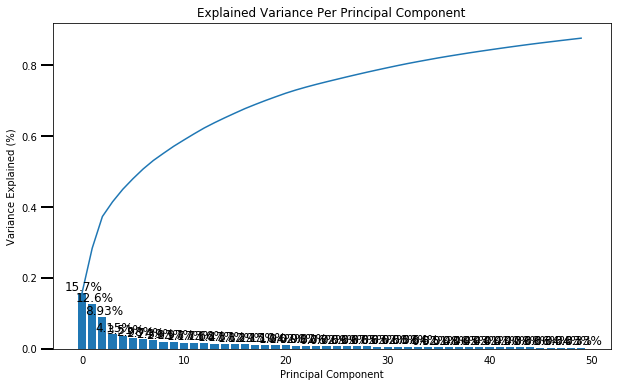

In [105]:
scree_plot(pca)

In [106]:
# Re-apply PCA to the data while selecting for number of components to retain.
import copy

pca, df_pca = do_pca(30, azdiastemp_noNa_final)

df_pca_orig = copy.deepcopy(df_pca)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

Reusing the code from the videos, we can see that the first 3 features account for around 35% of the variance of the data. We see that this variance quickly falls off as we have more and more features. From the above graph I think 30 features seems a fair number of features to retain, as this should account for around 80% of the variance in the data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [107]:
def getWeights(df, pca, weightIndex, N):
    weights = pd.DataFrame(pca.components_, columns=df.columns)
    weights = weights.iloc[weightIndex:weightIndex+1, :].transpose()
    posWeights = weights.sort_values(weights.columns[0], ascending=False).head(N)
    negWeights = weights.sort_values(weights.columns[0], ascending=True).head(N)
    return posWeights, negWeights

In [108]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
# and then print the linked values, sorted by weight.
p, n = getWeights(azdiastemp_noNa_final, pca, 0, 10)
p

0
PLZ8_ANTG3          0.222606
PLZ8_ANTG4          0.215934
ORTSGR_KLS9         0.198526
EWDICHTE            0.195974
HH_EINKOMMEN_SCORE  0.190977
FINANZ_SPARER       0.155443
FINANZ_HAUSBAUER    0.152013
KBA05_ANTG4         0.151090
PLZ8_ANTG2          0.148548
ARBEIT              0.141607

In [109]:
n

0
MOBI_REGIO           -0.239428
KBA05_ANTG1          -0.222922
FINANZ_MINIMALIST    -0.222529
PLZ8_ANTG1           -0.221995
KBA05_GBZ            -0.214801
PLZ8_GBZ             -0.166337
INNENSTADT           -0.165851
KONSUMNAEHE          -0.165035
ALTERSKATEGORIE_GROB -0.137991
BALLRAUM             -0.128487

In [110]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
p, n = getWeights(azdiastemp_noNa_final, pca, 1, 10)


In [111]:
p

1
ALTERSKATEGORIE_GROB  0.252765
SEMIO_ERL             0.235743
FINANZ_VORSORGER      0.217776
SEMIO_LUST            0.175344
RETOURTYP_BK_S        0.161684
SEMIO_KRIT            0.130653
SEMIO_KAEM            0.122912
FINANZ_HAUSBAUER      0.122652
W_KEIT_KIND_HH        0.118632
PLZ8_ANTG3            0.104754

In [112]:
n

1
SEMIO_REL             -0.262923
SEMIO_PFLICHT         -0.231305
SEMIO_KULT            -0.225357
SEMIO_TRADV           -0.225101
FINANZ_SPARER         -0.223603
FINANZ_UNAUFFAELLIGER -0.217697
FINANZ_ANLEGER        -0.195253
SEMIO_FAM             -0.184628
ONLINE_AFFINITAET     -0.164147
SEMIO_RAT             -0.163079

In [113]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
p, n = getWeights(azdiastemp_noNa_final, pca, 2, 10)


In [114]:
p

2
SEMIO_VERT            0.345306
SEMIO_SOZ             0.256961
SEMIO_FAM             0.242939
SEMIO_KULT            0.220989
FINANZ_MINIMALIST     0.162318
RETOURTYP_BK_S        0.123113
FINANZ_VORSORGER      0.107471
W_KEIT_KIND_HH        0.099203
ALTERSKATEGORIE_GROB  0.095271
SEMIO_LUST            0.081573

In [115]:
n

2
ANREDE_KZ             -0.364546
SEMIO_KAEM            -0.334261
SEMIO_DOM             -0.311411
SEMIO_KRIT            -0.264220
SEMIO_RAT             -0.227216
FINANZ_ANLEGER        -0.195261
SEMIO_ERL             -0.158497
FINANZ_SPARER         -0.111787
FINANZ_UNAUFFAELLIGER -0.103077
SEMIO_TRADV           -0.097060

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [116]:
from sklearn.cluster import KMeans

In [117]:
from joblib import dump, load

In [118]:
# cluster0 = KMeans(10)
# result0 = cluster0.fit_transform(df_pca)
# distance0 = np.min(result0, axis=1)
# dump(cluster0, 'cluster0')
# print(distance0)

In [119]:
# cluster1 = KMeans(11)
# result1 = cluster1.fit_transform(df_pca)
# distance1 = np.min(result1, axis=1)
# dump(cluster1, 'cluster1')
# print(distance1)

In [120]:
# cluster2 = KMeans(12)
# result2 = cluster2.fit_transform(df_pca)
# distance2 = np.min(result2, axis=1)
# dump(cluster2, 'cluster2')
# print(distance2)

In [121]:
# cluster3 = KMeans(13)
# result3 = cluster3.fit_transform(df_pca)
# distance3 = np.min(result3, axis=1)
# dump(cluster3, 'cluster3')
# print(distance3)

In [122]:
# cluster4 = KMeans(14)
# result4 = cluster4.fit_transform(df_pca)
# distance4 = np.min(result4, axis=1)
# dump(cluster4, 'cluster4')
# print(distance4)

In [123]:
# cluster5 = KMeans(15)
# result5 = cluster5.fit_transform(df_pca)
# distance5 = np.min(result5, axis=1)
# dump(cluster5, 'cluster5')
# print(distance5)

In [124]:
# cluster6 = KMeans(16)
# result6 = cluster6.fit_transform(df_pca)
# distance6 = np.min(result6, axis=1)
# dump(cluster6, 'cluster6')
# print(distance6)

In [125]:
# cluster7 = KMeans(17)
# result7 = cluster7.fit_transform(df_pca)
# distance7 = np.min(result7, axis=1)
# dump(cluster7, 'cluster7')
# print(distance7)

In [126]:
# cluster8 = KMeans(18)
# result8 = cluster8.fit_transform(df_pca)
# distance8 = np.min(result8, axis=1)
# dump(cluster8, 'cluster8')
# print(distance8)

In [127]:
# cluster9 = KMeans(19)
# result9 = cluster9.fit_transform(df_pca)
# distance9 = np.min(result9, axis=1)
# dump(cluster9, 'cluster9')
# print(distance9)

In [128]:
cluster0 = load('cluster0')
cluster1 = load('cluster1')
cluster2 = load('cluster2')
cluster3 = load('cluster3')
cluster4 = load('cluster4')
cluster5 = load('cluster5')
cluster6 = load('cluster6')
cluster7 = load('cluster7')
cluster8 = load('cluster8')
cluster9 = load('cluster9')

In [129]:
result0 = cluster0.transform(df_pca)
distance0 = np.min(result0, axis=1)
print(distance0)
result1 = cluster1.transform(df_pca)
distance1 = np.min(result1, axis=1)
print(distance1)
result2 = cluster2.transform(df_pca)
distance2 = np.min(result2, axis=1)
print(distance2)
result3 = cluster3.transform(df_pca)
distance3 = np.min(result3, axis=1)
print(distance3)
result4 = cluster4.transform(df_pca)
distance4 = np.min(result4, axis=1)
print(distance4)
result5 = cluster5.transform(df_pca)
distance5 = np.min(result5, axis=1)
print(distance5)
result6 = cluster6.transform(df_pca)
distance6 = np.min(result6, axis=1)
print(distance6)
result7 = cluster7.transform(df_pca)
distance7 = np.min(result7, axis=1)
print(distance7)
result8 = cluster8.transform(df_pca)
distance8 = np.min(result8, axis=1)
print(distance8)
result9 = cluster9.transform(df_pca)
distance9 = np.min(result9, axis=1)
print(distance9)

[ 5.99920356  5.25322915  6.26760652 ...,  4.92803458  5.6262381
  6.55423197]
[ 5.99729642  5.19941681  5.80185611 ...,  4.91543697  5.49068444
  6.23846466]
[ 6.00321557  5.38155623  5.71584121 ...,  4.93191586  5.4907225
  6.14040449]
[ 6.00392766  5.37278726  5.7805062  ...,  4.93259741  5.48580282
  6.21427945]
[ 5.86017994  5.66220384  5.77913626 ...,  4.60380248  5.48047593
  6.21966435]
[ 5.99451958  5.32246457  5.88282276 ...,  4.92354011  5.46000209
  5.49646623]
[ 5.92187825  5.0573057   5.77767642 ...,  4.4821897   5.48267078
  6.21543802]
[ 6.0017645   5.51875852  6.02450863 ...,  4.92603213  5.42898455
  5.90105521]
[ 5.92034543  5.03588893  5.815679   ...,  4.48228893  5.49018974
  6.33747584]
[ 5.92737572  5.04822523  5.88351874 ...,  4.48506609  5.1921062
  5.66267788]


In [130]:
resultList = [distance0, distance1, distance2, distance3, distance4, distance5, distance6, distance7, distance8, distance9]

In [131]:
resultListAvg = []
for i, j in zip(resultList, range(0, len(resultList))):
    resultListAvg.append(np.mean(i))
    print(f'Average of {j} is: {resultListAvg[j]}')

Average of 0 is: 5.491091752413104
Average of 1 is: 5.432722028994438
Average of 2 is: 5.3953931307323435
Average of 3 is: 5.347826619987956
Average of 4 is: 5.317350436694105
Average of 5 is: 5.286875239748684
Average of 6 is: 5.249543196370822
Average of 7 is: 5.242796093423207
Average of 8 is: 5.207815480022285
Average of 9 is: 5.191018052005388


Text(0,0.5,'Distance to nearest cluster centre')

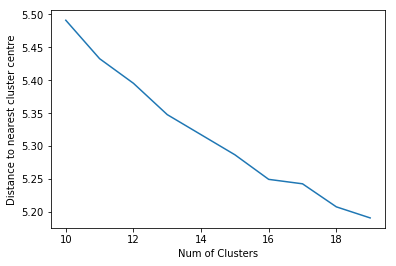

In [132]:
x = range(10, 20)
plt.plot(x, resultListAvg)
plt.xlabel('Num of Clusters')
plt.ylabel('Distance to nearest cluster centre')

## Answer

Unfortunately I ran into memory issues on this VM I couldn't get any further even with refreshing the workspace. If this were a real piece of work - I would go back and optimise my code (I suspect I am wasting a lot of memory here) however I don't want to go back and change things as it currently works for this project.

I am on my work laptop which is not powerful and I am unable to access my desktop at home. I hope you can see that the average distance to the centres is decreasing for increasing clusters!. 

I suspect that we will soon see this decrease slow down and eventually reach an optimum number of clusters.

As such I am choosing **19 clusters** for the model.

We have already got the results for this:

In [133]:
result9


array([[  8.89676907,  11.18238063,   9.44552392, ...,   7.78952809,
          8.01786661,  23.62727942],
       [  7.98911824,   8.06703566,   7.30671633, ...,   8.28362807,
          6.64715697,  23.42522223],
       [  9.89697642,   6.97460371,   5.88351874, ...,   8.04631183,
          9.80914733,  24.07789033],
       ..., 
       [  9.49078454,  10.88099939,   8.75271193, ...,   7.85142571,
          7.23220293,  23.94232482],
       [ 11.30937033,  11.41794303,   9.05660614, ...,   7.33669112,
         10.55966618,  24.50789177],
       [  9.35820758,   7.75844345,   5.66267788, ...,   7.50301775,
         10.07965876,  23.58627624]])

### Discussion 3.1: Apply Clustering to General Population

I have explained above what I've done but I will recap.

We fitted KMeans to our final dataset starting at k=5 to k=14. Unfortunately I had to stop at k=14 due to memory problems but we can see that as we are increasing k the distance to the nearest cluster centre is decreasing. For higher k we will eventually find a sweet spot for our data.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [134]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
print(customers.shape)
customers.head(3)

(191652, 85)


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         2                     4          1            5.0   
1        -1                     4          1            NaN   
2        -1                     4          2            2.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      2                 2    ...            3.0         3.0   
1                      3                 2    ...            NaN         NaN   
2                      4                 4    ...            2.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         1.0         0.0          1.0       5.0       5.0     1.0   
1         NaN         NaN          NaN       NaN       NaN     NaN   
2         3.0         1.0          3.0       3.0       2.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          2.0       1.0  
1          NaN       NaN  
2          5.0       3.0  

[3 rows x 85 columns]

In [135]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



In [136]:
# Fill in missing values:

for col, index in zip(customers, range(len(missing_list))):
    print(col, index)
    customers.iloc[:,index] = customers.iloc[:,index].apply(replace, items=missing_list[index], axis=1)

AGER_TYP 0
ALTERSKATEGORIE_GROB 1
ANREDE_KZ 2
CJT_GESAMTTYP 3
FINANZ_MINIMALIST 4
FINANZ_SPARER 5
FINANZ_VORSORGER 6
FINANZ_ANLEGER 7
FINANZ_UNAUFFAELLIGER 8
FINANZ_HAUSBAUER 9
FINANZTYP 10
GEBURTSJAHR 11
GFK_URLAUBERTYP 12
GREEN_AVANTGARDE 13
HEALTH_TYP 14
LP_LEBENSPHASE_FEIN 15
LP_LEBENSPHASE_GROB 16
LP_FAMILIE_FEIN 17
LP_FAMILIE_GROB 18
LP_STATUS_FEIN 19
LP_STATUS_GROB 20
NATIONALITAET_KZ 21
PRAEGENDE_JUGENDJAHRE 22
RETOURTYP_BK_S 23
SEMIO_SOZ 24
SEMIO_FAM 25
SEMIO_REL 26
SEMIO_MAT 27
SEMIO_VERT 28
SEMIO_LUST 29
SEMIO_ERL 30
SEMIO_KULT 31
SEMIO_RAT 32
SEMIO_KRIT 33
SEMIO_DOM 34
SEMIO_KAEM 35
SEMIO_PFLICHT 36
SEMIO_TRADV 37
SHOPPER_TYP 38
SOHO_KZ 39
TITEL_KZ 40
VERS_TYP 41
ZABEOTYP 42
ALTER_HH 43
ANZ_PERSONEN 44
ANZ_TITEL 45
HH_EINKOMMEN_SCORE 46
KK_KUNDENTYP 47
W_KEIT_KIND_HH 48
WOHNDAUER_2008 49
ANZ_HAUSHALTE_AKTIV 50
ANZ_HH_TITEL 51
GEBAEUDETYP 52
KONSUMNAEHE 53
MIN_GEBAEUDEJAHR 54
OST_WEST_KZ 55
WOHNLAGE 56
CAMEO_DEUG_2015 57
CAMEO_DEU_2015 58
CAMEO_INTL_2015 59
KBA05_ANTG1 60
KB

In [137]:
customers.head(10)

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       2.0                   4.0          1            5.0   
1       NaN                   4.0          1            NaN   
2       NaN                   4.0          2            2.0   
3       1.0                   4.0          1            2.0   
4       NaN                   3.0          1            6.0   
5       1.0                   3.0          1            4.0   
6       2.0                   4.0          1            2.0   
7       1.0                   4.0          1            2.0   
8       2.0                   4.0          2            1.0   
9       1.0                   3.0          1            3.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   
3                  5              1                 5               2   
4                  3              1                 4               4   
5                  5              1                 5               1   
6                  5              1                 5               1   
7                  5              1                 5               1   
8                  2              2                 5               1   
9                  5              2                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      2                 2    ...            3.0         3.0   
1                      3                 2    ...            NaN         NaN   
2                      4                 4    ...            2.0         3.0   
3                      1                 2    ...            3.0         2.0   
4                      5                 2    ...            2.0         4.0   
5                      2                 3    ...            2.0         3.0   
6                      1                 2    ...            3.0         2.0   
7                      2                 2    ...            3.0         3.0   
8                      1                 5    ...            1.0         4.0   
9                      3                 1    ...            3.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         1.0         0.0          1.0       5.0       5.0     1.0   
1         NaN         NaN          NaN       NaN       NaN     NaN   
2         3.0         1.0          3.0       3.0       2.0     3.0   
3         1.0         0.0          1.0       3.0       4.0     1.0   
4         2.0         1.0          2.0       3.0       3.0     3.0   
5         2.0         1.0          1.0       5.0       5.0     3.0   
6         1.0         0.0          1.0       5.0       5.0     2.0   
7         1.0         1.0          1.0       3.0       3.0     3.0   
8         2.0         1.0          5.0       5.0       4.0     3.0   
9         1.0         0.0          1.0       5.0       5.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          2.0       1.0  
1          NaN       NaN  
2          5.0       3.0  
3          3.0       1.0  
4          5.0       1.0  
5          7.0       5.0  
6          3.0       2.0  
7          4.0       3.0  
8          8.0       3.0  
9          6.0       4.0  

[10 rows x 85 columns]

In [138]:
# Find missing data by col

null_col_count_cust = customers.isnull().sum(axis=0)
ax_rows_cust = customers.shape[0]
anomalies_cust = null_col_count_cust.apply(findTotal, total=ax_rows_cust).sort_values(ascending=False)
anomalies_cust[0:10]

TITEL_KZ          0.987936
KK_KUNDENTYP      0.584064
KBA05_BAUMAX      0.571531
AGER_TYP          0.504759
GEBURTSJAHR       0.485380
ALTER_HH          0.358707
KKK               0.313401
REGIOTYP          0.313401
W_KEIT_KIND_HH    0.297085
KBA05_GBZ         0.292102
dtype: float64

## Answer

In the original dataset we dropped anything below 34.8%, I will do the same here so we will drop the first six of the above list

As we did above, I am keeping all rows regardless of how much is missing

In [139]:
customers.drop(['TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'AGER_TYP', 'GEBURTSJAHR', 'ALTER_HH'], axis=1, inplace=True)

In [140]:
assert customers.shape[1]+6 == 85

We can now look at reencoding our categorical features 

In [141]:
categorical_cols = feat_info_cat['attribute'].tolist()

drop_cols = ['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP']

for i in drop_cols:
    categorical_cols.remove(i)
    
print(categorical_cols)
print(len(categorical_cols))

['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
18


In [142]:
# Re-encode categorical variable(s) to be kept in the analysis.
for i in categorical_cols:
    print(f'{i}\nValues: {customers[i].unique()}\nLength: {len(customers[i].unique())}')
    if len(customers[i].unique()) == 2:
        categorical_cols.remove(i)
print('\n Columns to reencode as dummies:', categorical_cols)

ANREDE_KZ
Values: [1 2]
Length: 2
FINANZTYP
Values: [2 6 5 3 1 4]
Length: 6
GFK_URLAUBERTYP
Values: [  4.  nan   3.  10.   2.  11.   8.   1.   5.   9.  12.   7.   6.]
Length: 13
GREEN_AVANTGARDE
Values: [1 0]
Length: 2
LP_FAMILIE_GROB
Values: [  2.  nan   1.   5.   4.   3.]
Length: 6
LP_STATUS_FEIN
Values: [ 10.  nan   9.   1.   7.   6.   3.   5.   8.   4.   2.]
Length: 11
LP_STATUS_GROB
Values: [  5.  nan   4.   1.   3.   2.]
Length: 6
NATIONALITAET_KZ
Values: [  1.   2.  nan   3.]
Length: 4
SHOPPER_TYP
Values: [  3.   1.   0.   2.  nan]
Length: 5
SOHO_KZ
Values: [  0.  nan   1.]
Length: 3
VERS_TYP
Values: [  1.   2.  nan]
Length: 3
ZABEOTYP
Values: [3 1 2 4 6 5]
Length: 6
GEBAEUDETYP
Values: [  1.  nan   8.   2.   3.   4.   6.]
Length: 7
OST_WEST_KZ
Values: ['W' nan 'O']
Length: 3
CAMEO_DEUG_2015
Values: ['1' nan '5' '4' '7' '3' '9' '2' '6' '8']
Length: 10
CAMEO_DEU_2015
Values: ['1A' nan '5D' '4C' '7B' '3B' '1D' '9E' '2D' '4A' '6B' '9D' '8B' '5C' '9C'
 '4E' '6C' '8C' '8A' '5B' '9B' 

In [143]:
len(categorical_cols)

16

In [144]:
customers[categorical_cols].head(5)

CJT_GESAMTTYP  FINANZTYP  GFK_URLAUBERTYP  LP_FAMILIE_FEIN  \
0            5.0          2              4.0              2.0   
1            NaN          2              NaN              NaN   
2            2.0          2              3.0              1.0   
3            2.0          6             10.0              NaN   
4            6.0          2              2.0             10.0   

   LP_FAMILIE_GROB  LP_STATUS_FEIN  LP_STATUS_GROB  NATIONALITAET_KZ  \
0              2.0            10.0             5.0               1.0   
1              NaN             NaN             NaN               1.0   
2              1.0            10.0             5.0               1.0   
3              NaN             9.0             4.0               1.0   
4              5.0             1.0             1.0               1.0   

   SHOPPER_TYP  SOHO_KZ  VERS_TYP  ZABEOTYP  GEBAEUDETYP OST_WEST_KZ  \
0          3.0      0.0       1.0         3          1.0           W   
1          3.0      0.0       1.0         3          NaN         NaN   
2          1.0      0.0       2.0         3          8.0           W   
3          0.0      0.0       1.0         1          2.0           W   
4          1.0      0.0       2.0         1          3.0           W   

  CAMEO_DEUG_2015 CAMEO_DEU_2015  
0               1             1A  
1             NaN            NaN  
2               5             5D  
3               4             4C  
4               7             7B

In [145]:
customers_cat_dummies = pd.get_dummies(customers[categorical_cols].astype(str))
customers_cat_dummies.head(5)

CJT_GESAMTTYP_1.0  CJT_GESAMTTYP_2.0  CJT_GESAMTTYP_3.0  CJT_GESAMTTYP_4.0  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  1                  0                  0   
3                  0                  1                  0                  0   
4                  0                  0                  0                  0   

   CJT_GESAMTTYP_5.0  CJT_GESAMTTYP_6.0  CJT_GESAMTTYP_nan  FINANZTYP_1  \
0                  1                  0                  0            0   
1                  0                  0                  1            0   
2                  0                  0                  0            0   
3                  0                  0                  0            0   
4                  0                  1                  0            0   

   FINANZTYP_2  FINANZTYP_3         ...          CAMEO_DEU_2015_8A  \
0            1            0         ...                          0   
1            1            0         ...                          0   
2            1            0         ...                          0   
3            0            0         ...                          0   
4            1            0         ...                          0   

   CAMEO_DEU_2015_8B  CAMEO_DEU_2015_8C  CAMEO_DEU_2015_8D  CAMEO_DEU_2015_9A  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   CAMEO_DEU_2015_9B  CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  CAMEO_DEU_2015_9E  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   CAMEO_DEU_2015_nan  
0                   0  
1                   1  
2                   0  
3                   0  
4                   0  

[5 rows x 147 columns]

In [146]:
feat_info_mixed = feat_info[(feat_info['type']=='mixed')]
feat_info_mixed

attribute information_level   type missing_or_unknown
15    LP_LEBENSPHASE_FEIN            person  mixed                [0]
16    LP_LEBENSPHASE_GROB            person  mixed                [0]
22  PRAEGENDE_JUGENDJAHRE            person  mixed             [-1,0]
56               WOHNLAGE          building  mixed               [-1]
59        CAMEO_INTL_2015     microcell_rr4  mixed            [-1,XX]
64           KBA05_BAUMAX     microcell_rr3  mixed             [-1,0]
79            PLZ8_BAUMAX    macrocell_plz8  mixed             [-1,0]

In [147]:
mixed_cols = feat_info_mixed['attribute'].tolist()

# drop_cols = ['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP']

# for i in drop_cols:
#     mixed_cols.remove(i)
    
print(mixed_cols)
print(len(mixed_cols))

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']
7


In [148]:
customers['PRAEGENDE_JUGENDJAHRE_decade'] = customers.loc[:,'PRAEGENDE_JUGENDJAHRE'].apply(PRAEGENDE_JUGENDJAHRE_decade, axis=1)
customers['PRAEGENDE_JUGENDJAHRE_decade'].head(5)

0    50.0
1     NaN
2    50.0
3    40.0
4    70.0
Name: PRAEGENDE_JUGENDJAHRE_decade, dtype: float64

In [149]:
customers['PRAEGENDE_JUGENDJAHRE_movement'] = customers.loc[:,'PRAEGENDE_JUGENDJAHRE'].apply(PRAEGENDE_JUGENDJAHRE_movement, axis=1)
customers['PRAEGENDE_JUGENDJAHRE_movement'].head(5)

0    avantgarde
1           NaN
2    avantgarde
3    mainstream
4    mainstream
Name: PRAEGENDE_JUGENDJAHRE_movement, dtype: object

In [150]:
customers.iloc[0:5, -2:]

PRAEGENDE_JUGENDJAHRE_decade PRAEGENDE_JUGENDJAHRE_movement
0                          50.0                     avantgarde
1                           NaN                            NaN
2                          50.0                     avantgarde
3                          40.0                     mainstream
4                          70.0                     mainstream

In [151]:
customers['CAMEO_INTL_2015_wealth'] = customers.loc[:,'CAMEO_INTL_2015'].apply(CAMEO_INTL_2015_wealth, axis=1)
customers['CAMEO_INTL_2015_wealth'].head(5)

0      1
1    NaN
2      3
3      2
4      4
Name: CAMEO_INTL_2015_wealth, dtype: object

In [152]:
customers['CAMEO_INTL_2015_life'] = customers.loc[:,'CAMEO_INTL_2015'].apply(CAMEO_INTL_2015_life, axis=1)
customers['CAMEO_INTL_2015_life'].head(5)

0      3
1    NaN
2      4
3      4
4      1
Name: CAMEO_INTL_2015_life, dtype: object

In [153]:
customers['CAMEO_INTL_2015'].iloc[0:5][:]

0     13
1    NaN
2     34
3     24
4     41
Name: CAMEO_INTL_2015, dtype: object

In [154]:
newCols = ['PRAEGENDE_JUGENDJAHRE_movement', 'PRAEGENDE_JUGENDJAHRE_decade', 'CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_life']
customers[newCols].head(5)

PRAEGENDE_JUGENDJAHRE_movement  PRAEGENDE_JUGENDJAHRE_decade  \
0                     avantgarde                          50.0   
1                            NaN                           NaN   
2                     avantgarde                          50.0   
3                     mainstream                          40.0   
4                     mainstream                          70.0   

  CAMEO_INTL_2015_wealth CAMEO_INTL_2015_life  
0                      1                    3  
1                    NaN                  NaN  
2                      3                    4  
3                      2                    4  
4                      4                    1

In [155]:
customers_mixed_dummies = pd.get_dummies(customers[newCols].astype(str))
customers_mixed_dummies.head(5)

PRAEGENDE_JUGENDJAHRE_movement_avantgarde  \
0                                          1   
1                                          0   
2                                          1   
3                                          0   
4                                          0   

   PRAEGENDE_JUGENDJAHRE_movement_mainstream  \
0                                          0   
1                                          0   
2                                          0   
3                                          1   
4                                          1   

   PRAEGENDE_JUGENDJAHRE_movement_nan  PRAEGENDE_JUGENDJAHRE_decade_40.0  \
0                                   0                                  0   
1                                   1                                  0   
2                                   0                                  0   
3                                   0                                  1   
4                                   0                                  0   

   PRAEGENDE_JUGENDJAHRE_decade_50.0  PRAEGENDE_JUGENDJAHRE_decade_60.0  \
0                                  1                                  0   
1                                  0                                  0   
2                                  1                                  0   
3                                  0                                  0   
4                                  0                                  0   

   PRAEGENDE_JUGENDJAHRE_decade_70.0  PRAEGENDE_JUGENDJAHRE_decade_80.0  \
0                                  0                                  0   
1                                  0                                  0   
2                                  0                                  0   
3                                  0                                  0   
4                                  1                                  0   

   PRAEGENDE_JUGENDJAHRE_decade_90.0  PRAEGENDE_JUGENDJAHRE_decade_nan  \
0                                  0                                 0   
1                                  0                                 1   
2                                  0                                 0   
3                                  0                                 0   
4                                  0                                 0   

             ...             CAMEO_INTL_2015_wealth_3  \
0            ...                                    0   
1            ...                                    0   
2            ...                                    1   
3            ...                                    0   
4            ...                                    0   

   CAMEO_INTL_2015_wealth_4  CAMEO_INTL_2015_wealth_5  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         1                         0   

   CAMEO_INTL_2015_wealth_nan  CAMEO_INTL_2015_life_1  CAMEO_INTL_2015_life_2  \
0                           0                       0                       0   
1                           1                       0                       0   
2                           0                       0                       0   
3                           0                       0                       0   
4                           0                       1                       0   

   CAMEO_INTL_2015_life_3  CAMEO_INTL_2015_life_4  CAMEO_INTL_2015_life_5  \
0                       1                       0                       0   
1                       0                       0                       0   
2                       0                       1                       0   
3                       0                       1                       0   
4                       0                       0              

In [156]:
customers.drop(['PRAEGENDE_JUGENDJAHRE_movement', 'PRAEGENDE_JUGENDJAHRE_decade',
       'CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_life'], axis=1, inplace=True)

In [157]:
len(customers.columns)

79

In [158]:
print(len(categorical_cols))
print(len(mixed_cols))
print()
print(len(customers_cat_dummies.columns))
print(len(customers_mixed_dummies.columns))

16
7

147
22


In [159]:
mixed_cols.remove('KBA05_BAUMAX')

In [160]:
mixed_cols

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [161]:
customers.drop(categorical_cols, axis=1, inplace=True)
customers.drop(mixed_cols, axis=1, inplace=True)

In [162]:
customerstemp = customers
customerstemp.head(2)

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   4.0          1                  5              1   
1                   4.0          1                  5              1   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0                 5               1                      2                 2   
1                 5               1                      3                 2   

   GREEN_AVANTGARDE  HEALTH_TYP    ...     KBA13_ANZAHL_PKW  PLZ8_ANTG1  \
0                 1         1.0    ...               1201.0         3.0   
1                 0         1.0    ...                  NaN         NaN   

   PLZ8_ANTG2  PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         3.0         1.0         0.0       5.0       5.0     1.0   
1         NaN         NaN         NaN       NaN       NaN     NaN   

   ORTSGR_KLS9  RELAT_AB  
0          2.0       1.0  
1          NaN       NaN  

[2 rows x 57 columns]

In [163]:
customerstemp = customerstemp.join(customers_cat_dummies)
customerstemp = customerstemp.join(customers_mixed_dummies)

In [164]:
customerstemp.head(5)

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   4.0          1                  5              1   
1                   4.0          1                  5              1   
2                   4.0          2                  5              1   
3                   4.0          1                  5              1   
4                   3.0          1                  3              1   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0                 5               1                      2                 2   
1                 5               1                      3                 2   
2                 5               1                      4                 4   
3                 5               2                      1                 2   
4                 4               4                      5                 2   

   GREEN_AVANTGARDE  HEALTH_TYP            ...             \
0                 1         1.0            ...              
1                 0         1.0            ...              
2                 1         2.0            ...              
3                 0         2.0            ...              
4                 0         3.0            ...              

   CAMEO_INTL_2015_wealth_3  CAMEO_INTL_2015_wealth_4  \
0                         0                         0   
1                         0                         0   
2                         1                         0   
3                         0                         0   
4                         0                         1   

   CAMEO_INTL_2015_wealth_5  CAMEO_INTL_2015_wealth_nan  \
0                         0                           0   
1                         0                           1   
2                         0                           0   
3                         0                           0   
4                         0                           0   

   CAMEO_INTL_2015_life_1  CAMEO_INTL_2015_life_2  CAMEO_INTL_2015_life_3  \
0                       0                       0                       1   
1                       0                       0                       0   
2                       0                       0                       0   
3                       0                       0                       0   
4                       1                       0                       0   

   CAMEO_INTL_2015_life_4  CAMEO_INTL_2015_life_5  CAMEO_INTL_2015_life_nan  
0                       0                       0                         0  
1                       0                       0                         1  
2                       1                       0                         0  
3                       1                       0                         0  
4                       0                       0                         0  

[5 rows x 226 columns]

We will now apply feature scaling

In [165]:
print(customerstemp.shape[0] - customerstemp.dropna().shape[0])
customerstemp_noNa = customerstemp.dropna()
customerstemp_noNa.shape

75520


(116132, 226)

In [166]:
customerstemp_noNa.drop(customers_cat_dummies.columns, axis=1, inplace=True)
customerstemp_noNa.drop(customers_mixed_dummies.columns, axis=1, inplace=True)
customerstemp_noNa.drop('GREEN_AVANTGARDE', axis=1, inplace=True)
customerstemp_noNa.head(4)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   4.0          1                  5              1   
2                   4.0          2                  5              1   
4                   3.0          1                  3              1   
5                   3.0          1                  5              1   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0                 5               1                      2                 2   
2                 5               1                      4                 4   
4                 4               4                      5                 2   
5                 5               1                      2                 3   

   HEALTH_TYP  RETOURTYP_BK_S    ...     KBA13_ANZAHL_PKW  PLZ8_ANTG1  \
0         1.0             5.0    ...               1201.0         3.0   
2         2.0             5.0    ...                433.0         2.0   
4         3.0             5.0    ...                513.0         2.0   
5         3.0             3.0    ...               1167.0         2.0   

   PLZ8_ANTG2  PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         3.0         1.0         0.0       5.0       5.0     1.0   
2         3.0         3.0         1.0       3.0       2.0     3.0   
4         4.0         2.0         1.0       3.0       3.0     3.0   
5         3.0         2.0         1.0       5.0       5.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          2.0       1.0  
2          5.0       3.0  
4          5.0       1.0  
5          7.0       5.0  

[4 rows x 56 columns]

In [167]:
scalerCust = StandardScaler()
scalerCust.fit(customerstemp_noNa)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [168]:
customers_noNa_scaled = pd.DataFrame(scaler.transform(customerstemp_noNa), columns=customerstemp_noNa.columns)

In [169]:
customers_noNa_scaled.isnull().values.any()

False

In [170]:
customerstemp_noNa = customerstemp.dropna()
customerstemp_noNa.drop(customers_noNa_scaled.columns, axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [171]:
customerstemp_noNa.isnull().values.any()

False

In [172]:
customerstemp_noNa_final = pd.merge(customerstemp_noNa.reset_index(), customers_noNa_scaled.reset_index(), right_index=True, left_index=True)

In [173]:
customerstemp_noNa_final.isnull().values.any()

False

In [174]:
customerstemp_noNa_final.drop(['index_x', 'index_y'], axis=1, inplace=True)

In [175]:
print(customerstemp_noNa_final.shape)
customerstemp_noNa_final.head(10)

(116132, 226)


GREEN_AVANTGARDE  CJT_GESAMTTYP_1.0  CJT_GESAMTTYP_2.0  CJT_GESAMTTYP_3.0  \
0                 1                  0                  0                  0   
1                 1                  0                  1                  0   
2                 0                  0                  0                  0   
3                 1                  0                  0                  0   
4                 1                  0                  1                  0   
5                 1                  0                  1                  0   
6                 1                  0                  0                  1   
7                 1                  0                  0                  1   
8                 0                  0                  0                  0   
9                 0                  0                  1                  0   

   CJT_GESAMTTYP_4.0  CJT_GESAMTTYP_5.0  CJT_GESAMTTYP_6.0  CJT_GESAMTTYP_nan  \
0                  0                  1                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  1                  0   
3                  1                  0                  0                  0   
4                  0                  0                  0                  0   
5                  0                  0                  0                  0   
6                  0                  0                  0                  0   
7                  0                  0                  0                  0   
8                  0                  1                  0                  0   
9                  0                  0                  0                  0   

   FINANZTYP_1  FINANZTYP_2    ...     KBA13_ANZAHL_PKW  PLZ8_ANTG1  \
0            0            1    ...             1.773626    0.791700   
1            0            1    ...            -0.536230   -0.231061   
2            0            1    ...            -0.295620   -0.231061   
3            0            0    ...             1.671367   -0.231061   
4            0            1    ...             2.071381    0.791700   
5            0            0    ...            -0.391864    0.791700   
6            0            1    ...             1.487902    0.791700   
7            0            1    ...             0.035219    1.814461   
8            0            0    ...             1.782649    0.791700   
9            0            0    ...            -0.091101   -1.253822   

   PLZ8_ANTG2  PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_HHZ  PLZ8_GBZ    ARBEIT  \
0    0.181378    -0.64373   -0.984345  1.440275  1.483855 -2.226515   
1    0.181378     1.38779    0.381459 -0.638548 -1.209678 -0.203820   
2    1.270764     0.37203    0.381459 -0.638548 -0.311834 -0.203820   
3    0.181378     0.37203    0.381459  1.440275  1.483855 -0.203820   
4   -0.908009    -0.64373   -0.984345  1.440275  1.483855 -1.215167   
5    0.181378    -0.64373    0.381459 -0.638548 -0.311834 -0.203820   
6    0.181378    -0.64373   -0.984345  1.440275  1.483855 -0.203820   
7   -0.908009    -0.64373   -0.984345 -0.638548 -0.311834 -1.215167   
8   -1.997396    -1.65949   -0.984345  0.400863  1.483855 -2.226515   
9    1.270764     1.38779    0.381459  1.440275 -0.311834 -0.203820   

   ORTSGR_KLS9  RELAT_AB  
0    -1.478616 -1.565428  
1    -0.171975 -0.084556  
2    -0.171975 -1.565428  
3     0.699119  1.396317  
4    -1.043069 -0.824992  
5    -0.607522 -0.084556  
6     0.263572  0.655880  
7    -0.171975 -1.565428  
8    -1.914163 -1.565428  
9     1.134666  1.396317  

[10 rows x 226 columns]

In [176]:
pca, df_pca = do_pca(30, customerstemp_noNa_final)

In [177]:
df_pca.shape

(116132, 30)

## Answer

Now we can apply kmeans on our fitted model from before!

In [178]:
cluster9

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=19, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [179]:
resultCust = cluster9.transform(df_pca)

In [180]:
customerClusters = cluster9.predict(df_pca)

In [181]:
popClusters = cluster9.labels_

## Answer
This plot shows us the number of points in each cluster. It is not very useful as we need to scale them **so they represent a percentage which we will do below**

In [182]:
testDf = pd.DataFrame(customerClusters, columns=['Cluster'])
print(testDf.nunique())
testDf[testDf['Cluster'] == 18]
pd.value_counts(testDf['Cluster'])

Cluster    18
dtype: int64


14    17464
15    13584
11    12668
2      9874
1      9647
4      8844
10     8623
13     8363
5      8040
16     6109
8      5274
6      2956
7      1510
9      1175
0       885
3       771
17      320
18       25
Name: Cluster, dtype: int64

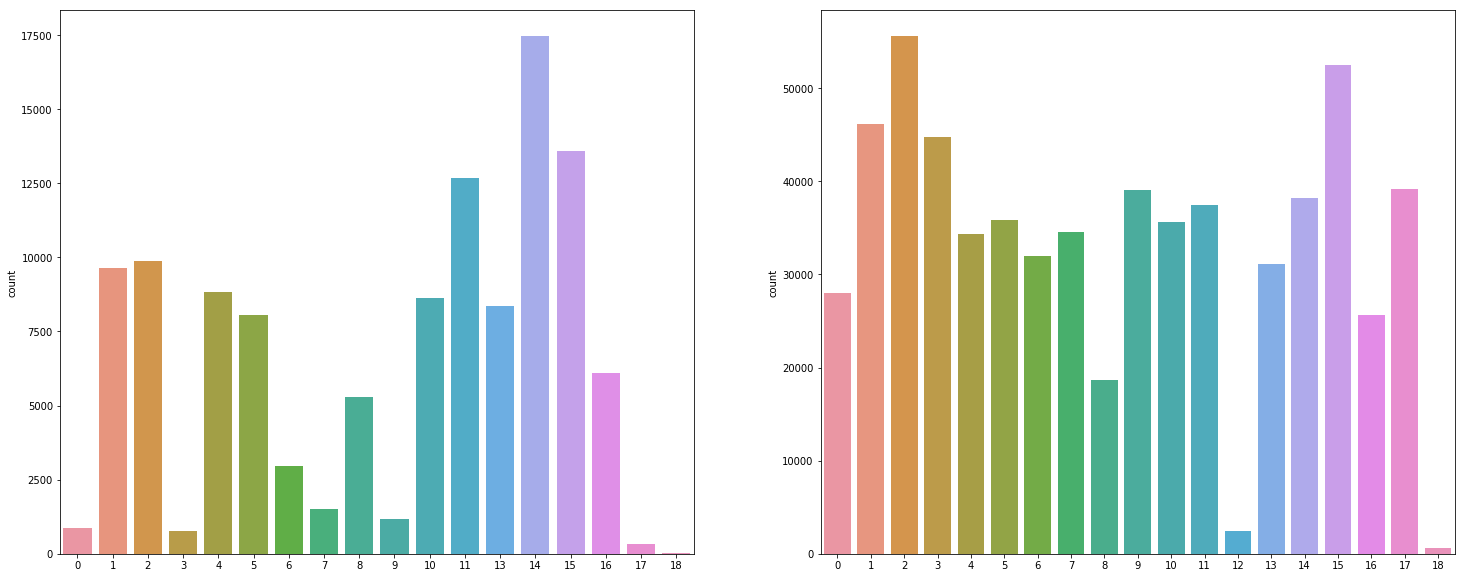

In [183]:
f, axes = plt.subplots(1, 2, figsize=(25, 10))
sns.countplot(x=customerClusters, ax=axes[0])
sns.countplot(popClusters, ax=axes[1])

In [184]:
index_cust=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18]

In [185]:
print(len(customerClusters))
print(len(df_pca))

116132
116132


In [186]:
def findClusterPerc(clusterSeries, df_pca, index=False):
    testDf = pd.DataFrame(clusterSeries, columns=['Cluster'])
    if index is False:
        return pd.DataFrame((pd.DataFrame(pd.value_counts((testDf['Cluster'].values))).values/len(df_pca)), columns=['Cluster'])
    else:
        return pd.DataFrame((pd.DataFrame(pd.value_counts((testDf['Cluster'].values))).values/len(df_pca)), columns=['Cluster'], index=index)


In [187]:
customerClustersPerc = findClusterPerc(customerClusters, df_pca, index=index_cust)

In [188]:
popClustersPerc = findClusterPerc(popClusters, df_pca_orig)

In [189]:
customerClustersPerc
# popClustersPerc

Cluster
0   0.150381
1   0.116970
2   0.109083
3   0.085024
4   0.083069
5   0.076155
6   0.074252
7   0.072013
8   0.069232
9   0.052604
10  0.045414
11  0.025454
13  0.013002
14  0.010118
15  0.007621
16  0.006639
17  0.002755
18  0.000215

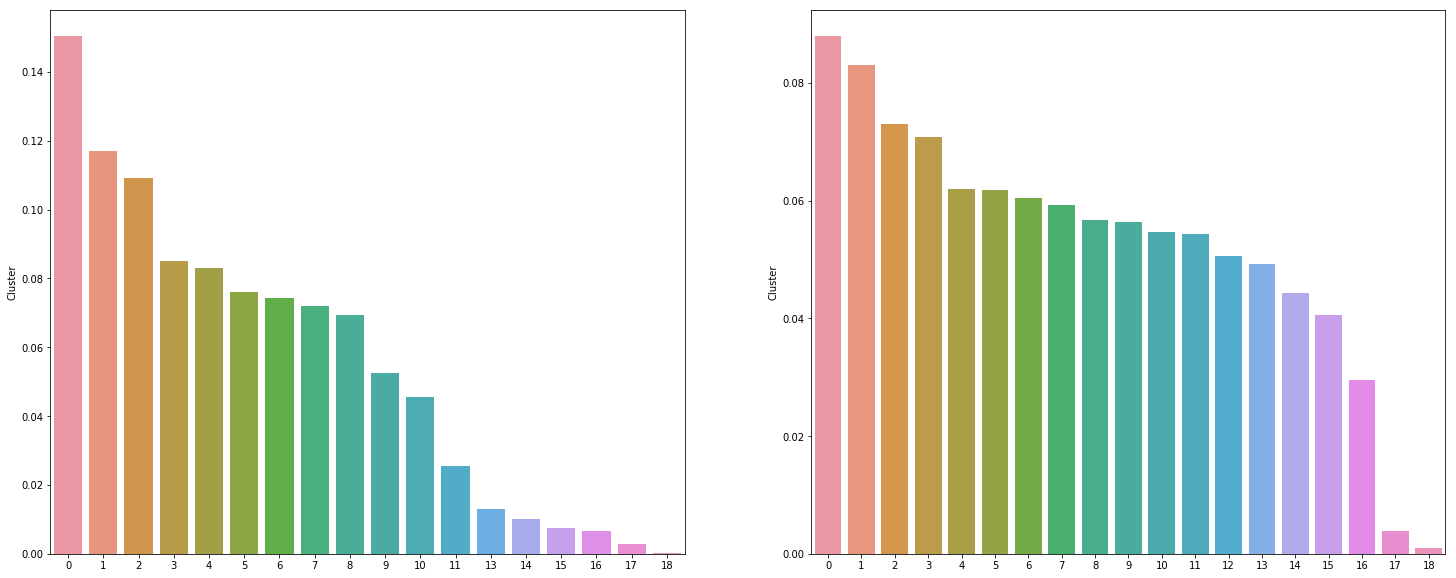

In [190]:
f, axes = plt.subplots(1, 2, figsize=(25, 10))
sns.barplot(y=customerClustersPerc['Cluster'], x=customerClustersPerc.index, ax=axes[0])
sns.barplot(y=popClustersPerc['Cluster'], x=popClustersPerc.index, ax=axes[1])

## Answer

We can see that in the left graph which represents the customer data, there are relatively more people towards the first clusters. On the right which represents our population data, it is more evenly spread out between the clusters.

In [191]:
print(pd.DataFrame(df_pca_orig).index.max())
print(anomaliesU_compare.index.max())

632125
891187


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.